___
<img align="left" width="30%" style="padding-right:10px;" src="images/Ccom.png">

# Basics of Gridding



### Created by Semme J. Dijkstra as introduction to Digital Terrain Modelling

The computer code in this notebook was mostly generated through chatGPT 4o and then heavily modified by Semme J. Dijkstra

v1.0.0: Semme J. Dijkstra: Initial version for use by Larry Mayer
___

In [1]:

%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
print('Python version: ' + sys.version)
from mycode.bathymetry import *
from mycode.projection import *

sys.path.append(os.getcwd())  # add the current folder to the list of paths where Python looks for modu

Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]


# Welcome

If you are reading this, you are likely learning about Ocean Mapping concepts. This document is an example of a **Jupyter notebook** which allows for mixing text with live python computer code. **Python** is a popular programming language that itself is free and open software - this is important as it allows you to use this Notebook without having to buy any software. 

The assumption made here is that you are a college graduate that is not familiar with computer coding: we will not shy away from introducing complex concepts, but at the same time we will not expect you to be able to produce code  other than for the most basic of tasks e.g., assigning a value to a parameter.

This Notebook is brought to you through the **e-learning Python for Ocean Mapping (ePOM)** initiative. It is likely that you are accessing this through the ePOM server which is configured to run these Notebooks seamlessly. However,  it is also possible to download this Notebook from [**GitHub**](https://github.com/semmed/Basics_of_gridding) and run it in your own environment if you prefer.

Running this Notebook on the ePOM server is beneficial to you; you do not have to worry about the environment being configured properly or having a computer that is powerful enough - we take care of that for you. All you need is a functional web-browser.

We use a number of icons to help you navigate the topic:

___

<img align="left" width="6%" style="padding-right:10px;" src="images/info.png"> This icon means that that the associated text may be of interest to you

___

___

<img align="left" width="6%" style="padding-right:10px;" src="images/key.png"> This icon means that that the associated text is of key importance

___
___

<img align="left" width="6%" style="padding-right:10px;" src="images/test.png"> This icon means that that the associated text contains an assigned task for you to complete

___
___
<img align="left" width="6%" style="padding-right:10px;" src="images/info.png">

Blue underlined text contains hyperlinks to other web pages e.g., if you want to [learn more about Python programming through ePOM](https://www.hydroffice.org/manuals/epom/python_basics_quickstart.html) then click on the link.
<br><br>
___




# Essential Definitions

In this notebook, we explore the representation of **bathymetry** through **gridding**. To ensure a clear understanding, we first define these terms using the  [*S32 IHO Hydrographic Dictionary*](http://iho-ohi.net/S32/engView.php) as a reference.


## Bathymetry

**Bathymetry** refers to the general configuration of the seafloor, determined through the analysis of depth data. In this context, **depth** is the vertical distance from a **chart datum** to the seafloor. Modern depth data is typically collected using a **MultiBeam EchoSounder** (**MBES**) which is an echosounder that collects an array of depths for each transmitted ping. 

___
## Digital Elevation Model


<img align="center" width="80%" style="padding-right:10px;" src="images/point_cloud.png">

Data sets collected with modern echosounders are often very large; containing many depth observations within a small area. While these observations represent the bottom, they are discrete points rather than a continuous bathymetric surface. The sheer volume of data, combined with the inherent noise contained within, complicates analysis and interpretation, as illustrated by the **point cloud** in the image above. 

<img align="center" width="80%" style="padding-right:10px;" src="images/gridded_data.png">
<img align="center" width="80%" style="padding-right:10px;" src="images/bottom_image.jpg">

The top image above demonstrates that a **Digital Surface Model** (**DSM**) can provide a much clearer representation of the bottom than the point cloud. Since depth data is in essence elevation data, such a DSM is often referred to as a **Digital Elevation Model** (**DEM**). The DEM presented here suggests the presence of sand waves, which is confirmed by the accompanying ground-truth photo of the same area. The model also allows for estimation and analysis of residuals in the depth data, enabling computation of descriptive statistics e.g., the uncertainty in the depth represented by the model.

We are generally interested in representing the seafloor as a continuous surface, which we just learned is known as bathymetry. To achieve this, depth observations are typically used in various ways to create DEMs - in this notebook we will focus on the most common ways to construct such a DEM.

<img align="center" width="70%" style="padding-right:10px;" src="images/tin.png">

One common approach to constructing a surface model involves generating a network of triangular facets that connect the soundings at their vertices. This technique is especially well-suited for relatively sparse datasets and results in a **Triangulated Irregular Network** (**TIN**) model where each depth measurement is represented as a distinct node. However, because each node corresponds directly to a single observation, there is no redundancy in the model, limiting the potential for statistical analysis based solely on the nodes. It should be noted here that the depth soundings represent small areas rather than a single point. For dense data these areas may overlap and the soundings are then correlated and redundant, the TIN does not reflect this in any way.  

<img align="left" width="6%" style="padding-right:10px;" src="images/info.png"> Nodes in a TIN can have associated uncertainty estimates; however, these are typically derived by propagating a-priori knowledge of data quality rather than by assessing the consistency of the observations at each node. Alternatively, some methods infer statistical properties based on the node's **topology**, analyzing the characteristics of adjacent nodes connected through the triangle vertices.

<img align="left" width="6%" style="padding-right:10px;" src="images/info.png">

**Topology** is the math concerned with the properties of geometry preserved under continuous deformations e.g., bending or stretching, but not tearing. The soundings connected through a TIN's vertices are neighboring, even if we stretch or bend the model this relation is preserved

___
<img align="center" width="70%" style="padding-right:10px;" src="images/grid.png">

Data sets collected with modern echosounders are often very large, representing them using **TIN**s is not efficient and makes that all the noise in the data is present in the resulting surface. It is typically more useful to represent the data by a statistical model of it. Usually MBES data is of sufficient spatial density to allow the construction of a geospatial grid. Grids can either be **structured** in which case the grid cells are in a regular framework of cells evenly spaced in distance, or it can be **unstructured** in which case the cell size varies, typically as a function of the data density of the area represented by a cell. In the case of this notebook we will restrict ourselves to structured grids. 

___
<img align="left" width="6%" style="padding-right:10px;" src="images/key.png"> Grid cell values are derived from multiple observations associated with each cell, introducing redundancy that enables the calculation of statistical measures for consistency and repeatability. Although a priori uncertainty estimates may still be used, their primary role is typically to assign appropriate weights to individual observations when estimating the representative value for each cell.
___

______
<img align="left" width="6%" style="padding-right:10px;" src="images/key.png">Unlike soundings, grid data points have no positional error, as their locations are user defined rather than measured. When horizontal uncertainty associated to soundings is properly propagated, the total uncertainty at each grid node can be expressed as a single depth uncertainty. This allows for the creation of an accompanying uncertainty grid that reflects *the combined horizontal and vertical uncertainties of the underlying sounding data*. How this is done will be addressed later in this Notebook.
___

<img align="center" width="70%" style="padding-right:10px;" src="images/node_cell_grid.png">

A final distinction to consider is between **node grids** and **cell (or pixel) grids**. In a node grid, grid values correspond to the corners of the cells, whereas in a cell grid, values represent the center of each cell. This is an important distinction as it affects how grid extents are interpreted and, consequently, the precise location of depth values. Notably, a node grid contains one additional row and column of data points compared to a cell grid covering the same spatial extent.

___

## Defining a Vertical Reference

Before we can model the data we need to address the reference frame of the observed depths and their positions. For the depths we use a **Chart Datum** (**CD**), which is a fixed vertical reference surface. Common examples of chart datums include:

- Water level surfaces, such as Mean Sea Level (**MSL**) or **Lowest Astronomical Tides**  (**LAT**)
- Mathematical models of the Earth's shape, such as **geoids** and **ellipsoids**.

<img align="center" width="50%" style="padding-right:10px;" src="images/GeoidEllipsoid.png">

Since we aim to position ourselves relative to the Earth, we need a geometric model of its shape. Using actual topography as a reference is impractical — otherwise, both the peak of *Mount Everest* and the deepest point of the *Mariana Trench* would have an elevation of 0m! What is needed then is a **Coordinate Reference System** (**CRS**) that allows for the *unique and meaningful definition* of point locations.


For elevations a commonly used reference is **Mean Sea Level**, but that immediately poses a problem: there is no sea level under Mount Everest. A common proxy for MSL is then an equipotential gravity field that best approximates MSL in the oceans. This equipotential surface is known as the geoid, represented in blue in the figure above. 


<img align="left" width="6%" style="padding-right:10px;" src="images/info.png"> A common misconception is that the magnitude of gravitational acceleration on the geoid is constant—often assumed to be $9.8 m/s^2$; this is not true. What is constant on the geoid, as an equipotential surface, is the gravitational potential energy of an object **not** the gravity acceleration that it experiences.

<br>
<br>
For vertical positioning, the geoid serves as an effective reference because distances from it define an object’s relative potential energy through:

$$E_{pot} = mgh$$

where $h$ is the distance along the plumb line from the geoid, and $g$ is the local gravitational acceleration. A key property of the geoid is that it is perpendicular to the direction of gravity, making it useful for applications such as hydrology, where accurate height differences are needed to predict water flow.

However, while the geoid (and tidal reference surfaces such as MSL) provide physically meaningful vertical references, their mathematical complexity can introduce ambiguities in distance and angle calculations, something we want to avoid in gridding.


## Horizontal and Vertical Positioning

To disambiguate and simplify the definition of distances and angles, locations were historically referenced to a theoretical sphere that approximates the size of the geoid. In this model, a point’s position is described using:

- **Latitude** and **longitude** for horizontal location.
- **Height** for vertical location as the orthogonal distance from the reference surface.

This distinction between horizontal and vertical locations is important because distances and angles between points are intrinsic properties of the reference surface and are calculated for a zero height i.e., on the surface. Consequently, the computed values depend on the chosen reference.

***One of the main goals of the science of geodesy is to develop and refine these reference surfaces.*** You may wonder why we discuss it here, it is relevant as using the wrong reference may lead to severe error in your results or, more commonly, error in the exchange or comparison of depth data models.


## The Role of the Ellipsoid

<img align="center" width="50%" style="padding-right:10px;" src="images/Ellipsoid.png">

A perfect sphere does not accurately model Earth’s shape, as the distortions due to earth's oblateness are too large for precise mapping. Instead, we use a **reference spheroid** aka **ellipsoid** — a mathematically simple figure that closely approximates the geoid. Such a spheroid is known as a **geodetic datum**.

Most reference spheroids are oblate ellipsoids of revolution, meaning that they are derived by rotating an ellipse around its minor axis as shown in the figure above. The semi-minor axis aligns with Earth's rotation axis, while the semi-major axis lies in the equatorial plane. This approach balances accuracy with computational efficiency.

For example, all Global Navigation Satellite Systems (GNSS), including GPS, report latitude and longitude relative to an ellipsoid - known as geodetic latitude and longitude. In the case of GPS, this reference is the World Geodetic System of 1984 (WGS84).


## Geodetic Latitude and Longitude

<img align="center" width="80%" style="padding-right:10px;" src="images/Geodetic_LL.png">

The coordinates given to you in this Notebook are known as **geodetic latitudes** $\varphi$ **and longitudes** $\lambda$, that is: latitudes and longitudes relative to a geodetic datum. First we will have to define what meridians and parallels are before we can express what latitudes and longitudes are.

The **poles** of the ellipsoid are where the semi-minor axis intersects the ellipsoid. A Meridian is then the intersection of the plane containing both the poles and a point of interest. This **meridian plane** is inherently ***orthogonal*** to the equatorial plane and the intersection with the ellipsoid is an ellipse referred to as a meridian. All points in this plane on one side of the rotational axis are said to have the same longitude, all points on the other side are offset by $180^{\circ}$. The difference in **geodetic longitude** between two points is then the angle in the equatorial plane between the meridian planes associated to them. To provide a useful datum a zero meridian has been chosen, it goes through a point near the **Greenwich** Royal observatory in England. The figure above left then illustrates longitude $\lambda$ relative to the Greenwich meridian $\lambda_0$. 

There are many 'flavors' of latitude, but the one that is most commonly used for positioning is named **geodetic latitude**. Geodetic latitude is defined by the line tangent to the meridian at a point of interest. Geodetic latitude $\varphi$ is then the angle between the line orthogonal to the tangent and the equatorial plane $\varphi_0$, as shown in the figure above on the right.


___

# Our Project Data

In this exercise you will combine bathymetry data from two separate point clouds to create a **Digital Elevation Model** (**DEM**). In the code cell below you will see your first bit of Python code


In [12]:
# Read the metadata of a sounding data set 

geodetic_bathy = ReadBathy('geodetic_bathy_data.txt','header')

Opened file: /home/jupyter-semmed/Modules/Basics_of_gridding/mydata/geodetic_bathy_data.txt


What the code shown above does is that it opens a sounding data set contained in the file `geodetic_bathy_data.txt` and reads the **header** data which is then assigned to the *variable* `geodetic_bathy` - In this case the header contains some data *about* the data that follows in the rest of the file - such data is known as **metadata** which we can print: 

In [13]:
print(geodetic_bathy)

horizontal units of measurement: degrees
vertical units of measurement: meters
projected coordinate units: NA
geoid name: NA
horizontal datum EPSG code: 7912
vertical datum: EPSG code: 7912
time basis: NA
proj projection string: NA



In this simple case it lists the *horizontal* and *vertical* datum and the **units of measurement**, or *scale* of the data that is to follow. You also see that there are some fields that lists that have the value `NA` - this mean that it is either not relevant, or not known

The datum fields contain so called [**EPSG** codes](https://epsg.org/home.html), which are codes for the **Coordinate Reference System**. The [EPSG Geodetic Parameter Dataset](https://epsg.org/home.html) contains definitions of coordinate reference systems and coordinate transformations which may be global, regional, national or local in application. It is maintained by the Geodesy Subcommittee of the IOGP Geomatics Committee. There are literally thousands of CRSs making it essential that a database such as the EPSG is maintained, so as to enable data exchange. The advantage of using numbers for the CRSs is that they are unambiguous - the disadvantage is that they are not very meaningful to the user. EPSG therefore also supplies a description of the CRS associated to each of the codes - let's have a look at the CRS described by the CRS associated to our geodetic bathy dataset.



In [4]:
from pyproj import CRS
CRS.from_epsg( 7912)

<Geographic 3D CRS: EPSG:7912>
Name: ITRF2014
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: International Terrestrial Reference Frame 2014
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Even with the little bit that you just learned about geodesy there is a lot of useful information here. It tells us that the coordinates in the file are going to be geodetic latitudes and longitudes with respect to a reference ellipsoid named GRS80, whose zero meridian is located at Greenwich - the units that should be used with this CRS are degrees and meters, which is consistent with the rest of our meta data. Additionally, this geodetic CRS is designed for global use, meaning its origin is located at the Earth's center of mass — a characteristic not shared by all CRSs. The CRS uses geodetic coordinates i.e., latitudes and longitudes that conform to the previously outlined convention. Finally our vertical datum is the surface of the GRS80 ellipsoid, and heights are defined as the orthogonal distance from this surface to a given point.

You may be wondering, "Why delve into all this complexity about coordinate systems? Can't we just start gridding?" Hopefully, this discussion has highlighted some of the pitfalls associated with different coordinate systems. Even something as straightforward as choosing a 5-meter grid resolution has different meaning for different CRSs. Understanding the importance of these nuances prevents unintended errors in spatial analysis.

___
<img align="left" width="6%" style="padding-right:10px;" src="images/info.png"> In this notebook we will take care of the details of handling the CRSs and hide most of the computer code from you.  An excellent introductory resource for CRSs is [pygis.io](https://pygis.io/docs/a_intro.html), specifically the section on the Nature of coordinate systems in Python.

___
<img align="left" width="6%" style="padding-right:10px;" src="images/key.png">Most images in this notebook are generated by Python code that is hidden from you. Most of this code is directly accessible in the notebook by selecting the image and then clicking on the<img src="images/carrot.png" width="3%" style="vertical-align: bottom; display: inline; margin-left: 5px; margin-right: 5px;">button in the toolbar - this will toggle the visibility of the code.

___ 
<img align="left" width="6%" style="padding-right:10px;" src="images/info.png"> 

The remainder of the code may be found in the [mycode](./mycode/) folder located in the same folder that this notebook is contained.
<br><br>



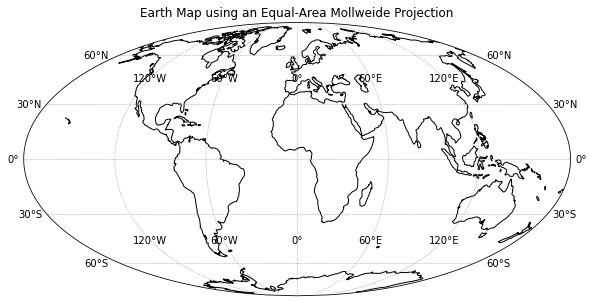

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create the figure and axis with an Mollweide projection
fig, ax = plt.subplots(figsize=(9.8, 6), subplot_kw={'projection': ccrs.Mollweide()})

# Set global extent
ax.set_global()

# Add coastlines for reference
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Set title
ax.set_title("Earth Map using an Equal-Area Mollweide Projection", fontsize=12)

# Show the plot
plt.show();

___
<img align="left" width="6%" style="padding-right:10px;" src="images/test.png"> As a first exercise we will have you visualize and then hide the code for the image above. Click on the image and then use the <img src="images/carrot.png" width="3%" style="vertical-align: bottom; display: inline; margin-left: 5px; margin-right: 5px;">button in the menu bar for this purpose.

___

As a matter of fact, we need to delve a little deeper into CRSs. Above you see the world's coastlines depicted in an equal-area projection - that is: two different areas of equal size in the map represent two areas of equal size on the reference ellipsoid used.

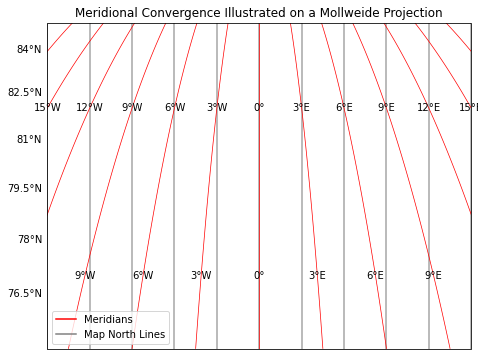

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from matplotlib.lines import Line2D  # For custom legend handles

# Create the figure with a Mollweide projection
fig, ax = plt.subplots(figsize=(9.8, 6), subplot_kw={'projection': ccrs.Mollweide()})

# Set extent: 10°x10° box around the North Pole in PlateCarree
ax.set_extent([-10, 10, 75, 85], crs=ccrs.PlateCarree())

# Add gridlines and configure them
gl = ax.gridlines(draw_labels=True, linewidth=0.7, color='red', alpha=1, linestyle='-')
gl.xlocator = MultipleLocator(3)
gl.ylines = False
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# Add "Map North" lines at each longitude
longitudes = np.linspace(-10, 10, 11)
for lon in longitudes:
    xs, ys = ccrs.Mollweide().transform_point(lon, 75, ccrs.PlateCarree())
    xn, yn = ccrs.Mollweide().transform_point(lon, 85, ccrs.PlateCarree())
    ax.plot([xs, xs], [ys, yn], color='gray', alpha=0.7, linestyle='-', linewidth=1.5)

# Create custom legend handles
legend_elements = [
    Line2D([0], [0], color='red', lw=1.5, linestyle='-', label='Meridians'),
    Line2D([0], [0], color='gray', lw=1.5, linestyle='-', label='Map North Lines')
]

# Add the legend to the plot
ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)

# Title
ax.set_title("Meridional Convergence Illustrated on a Mollweide Projection", fontsize=12)

# Show the plot
plt.show()

Geodetic coordinates are **curvilinear**, the distance between meridians varies with latitude. This spacing is widest at the equator and converges to zero at the poles — a phenomenon known as **meridional convergence**. Meridional convergence is illustrated in the figure above.

It is sometimes assumed that latitude and longitude intervals can be treated as if they represent equal distances i.e., there is no meridional convergence. This is often referred to as using "unprojected data," ***This is a misnomer***. The Earth's surface has **non-zero Gaussian curvature**, which means it's curved in both the north-south and east-west directions. Because of this, you can't flatten it onto a plane without some distortion. So, whenever we try to represent the Earth's surface on a flat map, we have to use a **projection** — a method for translating curved surface features onto a flat surface.

Map projections fall into four main categories:

- Conformal: Preserves angles between intersecting lines.
- Equal-area: Maintains relative area proportions.
- Equidistant: Preserves distances along specific standard lines.
- Compromise: Minimizes overall distortion but preserves no single geometric property exactly.

It should be noted that there actually is a name for what is often referred to as *unprojected data*, it is known as the **Plate-Carree** projection and is extremely important when defining CRS transformations. 

___
<img align="left" width="6%" style="padding-right:10px;" src="images/info.png">
If you have an interest in Python coding you can see an example of the usage of the Plate Carree CRS when expanding the code cell above - revealing the code used to generate the image
<br><br>

___

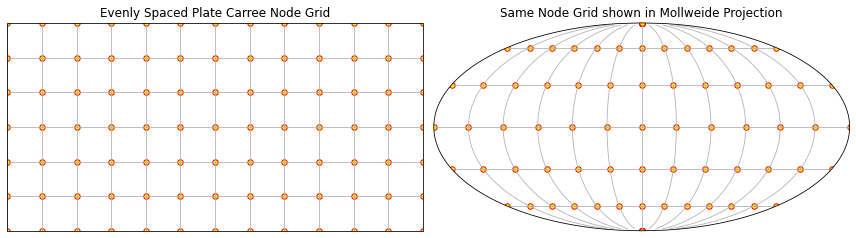

In [7]:
# Create a Plate Caree and a Mollweide map of the same node grid

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from numpy import pi

# Add a lat lon meshgrid of points
# Define the range and step size
lon_range = np.arange(-180, 181, 30)
lat_range = np.arange(-90, 91, 30)

# Create the meshgrid
lon, lat = np.meshgrid(lon_range, lat_range)

# Define the projections
projections = {'platecarree': ccrs.PlateCarree(), 'mollweide': ccrs.Mollweide()}

# Create figure and subplots with the specified projections

fig, ax = plt.subplots(1, 2, figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# First subplot (Plate Carree Projection)
ax[0].set_global()
ax[0].set_title('Evenly Spaced Plate Carree Node Grid')

# Add gridlines without labels
gl = ax[0].gridlines(draw_labels=False, xlocs=np.linspace(-180, 180, 13), ylocs=np.linspace(-90, 90, 7))
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# plot the grid nodes
ax[0].scatter(lon, lat, c='yellow', edgecolors='red', s=30, transform=ccrs.PlateCarree())

# Second subplot (Mollweide Projection)
ax[1] = plt.subplot(1, 2, 2, projection=ccrs.Mollweide())
ax[1].set_title('Same Node Grid shown in Mollweide Projection')

gl = ax[1].gridlines(draw_labels=False, xlocs=np.linspace(-180, 180, 13), ylocs=np.linspace(-90, 90, 7))


gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

# plot the grid nodes
ax[1].scatter(lon, lat, c='yellow', edgecolors='red', s=30, transform=ccrs.PlateCarree())


# Show the plot
plt.tight_layout()
plt.show()

While it is certainly possible to create a grid spaced evenly in geodetic coordinates — and some global datasets are distributed this way — it is important to recognize that the spatial density of the data contained therein is not uniform. This may be observed in the plots of a nodal grid above. The left plot shows points of evenly spaced latitudes and longitudes in the Plate Carree projection, whereas the plot on the right shows the same nodes in an equal area projection (Mollweide). In the equal-area projection it may be observed that the convergence of meridians toward the poles causes grid cell sizes to cover progressively smaller ground areas, leading to inconsistencies in data representation and analysis. This becomes particularly noticeable near the poles where the cells become trilaterals instead of quadrilaterals - what can't be seen is that each of the poles is covered by, in this case, thirteen nodes that may contain conflicting information - this is fundamentally inconsistent with the idea that a grid should have a single scalar value for each node i.e., be unambiguous.

___
<img align="left" width="6%" style="padding-right:10px;" src="images/info.png"> some grids may have several values per data point, this must be accompanied by a **disambiguation method** that uniquely identifies which of the values to use for a given purpose.
<br><br>
___

# What CRS Should you Use?


We have seen that we can classify projections by how they distort geometry. Ideally we reach an appropriate balance between these forms of distortion, often achieved through the use a **'Compromise'** projection. Unfortunately there is not a single best compromise. Here, we will suggest a few projections to use with an indication of some of their benefits and deficits. Going into great detail would distract too much, but excellent information is available. The USGS developed a Decision Support System (DSS) to guide users on the selection of an appropriate map projection, this is available as a chapter in the book [Choosing a Map Projection](https://link.springer.com/book/10.1007/978-3-319-51835-0). There is also a convenient online [projection wizard](https://projectionwizard.org) tool, a paper describing this tool may be found [here](https://berniejenny.info/pdf/2016_Savric_etal_ProjectionWizard.pdf).


## Mid latitudes

For most ocean mapping purposes we use either the **UTM (Universal Transverse Mercator)** or the **Lambert Conformal Conic (LCC)** projection for mapping and gridding, their suitability depends on the shape and extent of the area you're working with. UTM is by far the most commonly used projection for ocean mapping at mid latitudes, but has the limitation that the projection is valid only for a limited area. There really is 120 UTM projections: 60 $6^\circ$ wide projections in both the Northern and Southern hemisphere. Each one of these is referred to as a UTM zone




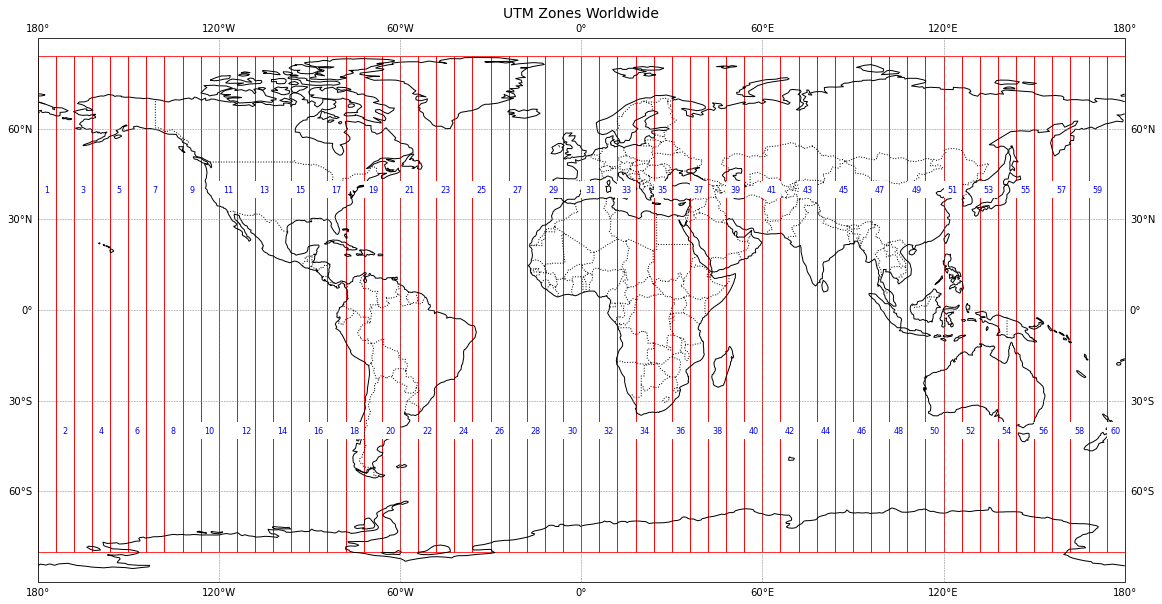

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create figure and axis with PlateCarree projection
fig, ax = plt.subplots(figsize=(30, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

# Define UTM zone boundaries
for zone in range(1, 61):
    lon_min = -180 + (zone - 1) * 6
    lon_max = lon_min + 6
    lat_min, lat_max = -80, 84  # UTM zone extent
    
    # Place even zone labels in the Southern Hemisphere, odd zones in the Northern Hemisphere
    label_lat = -40 if zone % 2 == 0 else 40
    ax.text(lon_min + 3, label_lat, str(zone), ha='center', va='center', fontsize=8, color='blue',
            transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

for zone in range(1, 61):
    lon_min = -180 + (zone - 1) * 6
    lon_max = lon_min + 6
    lat_min, lat_max = -80, 84  # UTM zone extent
    
    ax.add_patch(plt.Rectangle(
        (lon_min, lat_min), 6, lat_max - lat_min,
        facecolor='none', edgecolor='red', linewidth=0.8, transform=ccrs.PlateCarree(), alpha=1
    ))
    


# Set title and show plot
ax.set_title("UTM Zones Worldwide", fontsize=14)
plt.show()

In [9]:
latlon_to_utm_zone(43.1357, -70.9394)

(19, 'N')

In the figure above you see the various UTM zones. The [latlon_to_utm_zone()](./mycode/projection.py) function in the code cell above returns the number 19 and the letter N indicating that the Center for Coastal and Ocean Mapping, located at $43.1357^\circ N, -70.9394^\circ E$ in reference to the ITRF2014 CRS, is contained within the 19th zone on the Northerh hemisphere.

Though UTM is by far the most used projection in ocean mapping for latitudes between $80^\circ$S and $84^\circ$N it is not always the best choice. If you have data that significantly exceeds the valid area for the UTM zone it may be better to use the LCC projection. Though technically speaking another projection than either UTM or LCC could be better suited to your purpose it should be noted that it is almost guaranteed that your geospatial software (such as a GIS) is aware of the UTM and LCC projections, something that is not a given for other projections.


### **Which is Better: UTM or LCC?**
| Feature | UTM | Lambert Conformal Conic |
|---------|-----|------------------------|
| Best for | Small to medium areas | Medium to large areas |
| Orientation | North-South | East-West |
| Distortion | Increases outside UTM zone | Low between standard parallels |
| Shape Preservation | Good locally | Good over large areas |
| Example Uses | Local surveys, navigation, engineering | Regional mapping, meteorology, state-wide grids |

<img align="left" width="6%" style="padding-right:10px;" src="images/key.png"><br> **When NOT to Use UTM:**
- If your area spans more than one **UTM zones** (e.g., a wide east-west region).
- If you need a projection that works well over a **large regional area** more than $6^\circ$.

<img align="left" width="6%" style="padding-right:10px;" src="images/key.png"><br> **When NOT to Use LCC:**
- If your area is **small and local**, where UTM might be simpler and more precise.
- If your region is **mainly north-south oriented**, where UTM works better.

---

**If your area is small and falls within a single UTM zone, UTM is a great choice.**  
**If your area is larger and extends east-west across multiple UTM zones, LCC is better.**  



## High Latitudes

At high latitudes meridional convergence is very significant and both the LCC and UTM projections start distorting excessively. For these regions it is often best to select either the **Lambert Azimuthal Equal-Area (LAEA)** or the **Universal Polar Stereographic (UPS)** for **gridding DEMs**. Much like for the mid latitude projections we will not go into the details, but mention that the UPS is the most commonly used in ocean mapping. For very large regions the LAEA is generally preferable.


___
<img align="left" width="6%" style="padding-right:10px;" src="images/key.png"><br> **When NOT to Use LAEA:**
- If **distance accuracy** is important (distances are distorted away from the pole).
- If you need **compatibility with UTM** grids.

---

<img align="left" width="6%" style="padding-right:10px;" src="images/key.png"><br> **When NOT to Use UPS:**
- If you need **equal-area properties** (LAEA is better for mass balance and ice volume calculations).
- If you're working with a **very large region** spanning the entire polar area.

---

### Which is Better: UPS or LAEA?**
| **Feature** | **Lambert Azimuthal Equal-Area (LAEA)** | **Universal Polar Stereographic (UPS)** |
|------------|-----------------------------------|-----------------------------------|
| **Best for** | Large-area DEM grids | Medium-scale grids with UTM compatibility |
| **Distortion** | Preserves area, but distorts shapes | Preserves angles, but distorts distances |
| **Polar Coverage** | Full coverage of polar regions | Good for **84°N+ (North) and 80°S+ (South)** |
| **Use Cases** | Ice sheet analysis, mass balance, hydrology | Navigation, mapping, compatibility with UTM |

---
- **Choose LAEA** if you need accurate area calculations for applications such as glaciology and climate modeling.
- **Choose UPS** if you need a UTM-compatible system, as is common for navigation and engineering work.





___
<img align="left" width="6%" style="padding-right:10px;" src="images/info.png">
In ocean mapping we generally default to UTM projections for mid-latitudes (80S to 84N) and UPS for high latitudes. If you want your data to be consistent with other data sets that you use you may consider determining the projection used for these projections and selecting this for your work.
<br><br>

___

Much of the data that you will grid in this Notebook is referenced to WGS84 and uses either geodetic (EPSG: 4979) or UTM projected (EPSG: 32619) coordinates.

# Bathymetry data

You now have a basic idea about the types of DEMs and CRSs. Using this knowledge we will discuss how to generate structured DEMs from bathymetric data and how to apply gridding methods to create properly referenced DEMs.

Modern bathymetry data is typically collected with complex integrated systems that involve an extensive set of  sensors. Here we will not review the entire **processing pipeline** as that is an extensive subject. However, we will note that **MultiBeam Echosounder Systems** (**MBES**) are at the core of most modern data acquisition systems. The data that is provided to you here has already undergone all the transformations needed to turn raw data into soundings relative to a CRS. Such data is then referred to as **georeferenced data** and you may think of it as a point cloud. 


## **Common Gridding Techniques for DEMs (Digital Elevation Models)**  

Gridding is the process of interpolating scattered bathymetry points into a structured or unstructured grid format. As with projections there is a choice of a myriad of **gridding methods**. The best choice depends on factors like data density, terrain variability, and accuracy requirements. Below you will find a table generated by chatGPT comparing the most common techniques:


### **Comparison of DEM Gridding Techniques**
(source: chatGPT, accessed March 17, 2025 verified by experience)


| Method                     | **Nearest Neighbor (NN)** | **IDW (Inverse Distance Weighting)** | **Kriging** | **TIN to Raster** | **Natural Neighbor (NNI)** | **Spline Interpolation** |
|----------------------------|--------------------------|--------------------------------------|------------|------------------|--------------------------|-------------------------|
| **Best For**               | Categorical data, sparse points | Evenly distributed points | Spatially correlated elevation data | High-resolution terrain with sharp features | Smooth DEMs with natural transitions | Smooth surfaces like floodplains |
| **Pros**                   | Fast, preserves values | Simple, local control | Statistical accuracy, smooth | Preserves details, efficient for variable data | Smooth, robust to outliers | Very smooth DEMs |
| **Cons**                   | Blocky, no redundancy | Over-smoothing, no terrain details | Computationally expensive | Requires preprocessing | Computationally expensive | excessive smoothing, not appropriate for high relief |
| **How it Works** | Assigns the elevation value of the nearest known point to each grid cell. | Assigns values to grid points by taking a weighted average of nearby known points, with **closer points given more weight**. | Uses **statistical models** to estimate values based on spatial autocorrelation, optimizing for the best unbiased estimate. | Creates a **network of triangles** (TIN) from irregularly spaced elevation points, then interpolates values onto a raster grid. | Similar to IDW but selects a **variable set of nearest neighbors** to produce a more natural transition between points. | Uses mathematical splines (piecewise polynomials) to smoothly interpolate elevation points. |


---

### **Choosing the Right Gridding Method**
- **For general-purpose DEM gridding** → **IDW or Natural Neighbor**  
- **For high-accuracy terrain modeling** → **TIN to Raster or Kriging**  
- **For sharp features (mountains, ridges, valleys)** → **TIN-based methods**  
- **For smooth elevation models** → **Spline or Natural Neighbor**  

As you can see there are many techniques used for the creation of DEMs. There are actually many more than the ones listed in the table above - AI still has a way to go...

In our case we will focus on the **Inverse Distance Weighing** technique. Variations on this method are most commonly used for the dense data that is associated to modern bathymetric surveys.



___
## Inverse Distance Weighed (**IDW**) Gridding








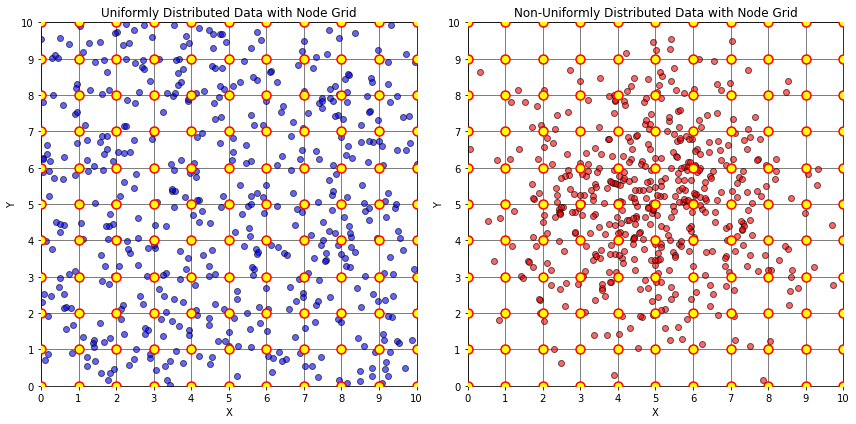

In [349]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

cur_folder = os.path.abspath(os.path.curdir)

# Load datasets from CSV files
data_path = os.path.join(cur_folder,'mydata', "uniform_data.csv")
uniform_data = pd.read_csv(data_path)

data_path = os.path.join(cur_folder,'mydata', "nonuniform_data.csv")
nonuniform_data = pd.read_csv(data_path)

# Extract X and Y values
x_uniform, y_uniform = uniform_data["X"], uniform_data["Y"]
x_nonuniform, y_nonuniform = nonuniform_data["X"], nonuniform_data["Y"]

# Define grid properties
grid_size = 1  # 1x1 grid cells
x_bins = np.arange(0, 11, grid_size)  # Bins from 0 to 10
y_bins = np.arange(0, 11, grid_size)

# Function to count points in each grid cell
def count_points_in_grid(x, y, x_bins, y_bins):
    heatmap, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])
    return heatmap.T  # Transpose to align correctly with the plot

# Count points in grid cells for both datasets
heatmap_uniform = count_points_in_grid(x_uniform, y_uniform, x_bins, y_bins)
heatmap_nonuniform = count_points_in_grid(x_nonuniform, y_nonuniform, x_bins, y_bins)

# Function to configure subplot appearance and overlay grid + nodes
def configure_subplot(ax, title, heatmap):
    ax.set_title(title)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xticks(x_bins)
    ax.set_yticks(y_bins)
    ax.grid(True, linestyle="-", c = 'black', linewidth=0.5, alpha=1)  # Grid lines


    # Plot node grid as red circles with yellow filling
    for x_coord in x_bins:
        for y_coord in y_bins:
            ax.scatter(x_coord, y_coord, color="yellow", edgecolors="red", s=80, linewidth=1.5, zorder=3)

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot uniform data
axes[0].scatter(x_uniform, y_uniform, c='blue', edgecolors='black', alpha=0.6, zorder=2)
configure_subplot(axes[0], "Uniformly Distributed Data with Node Grid", heatmap_uniform)

# Plot non-uniform data
axes[1].scatter(x_nonuniform, y_nonuniform, c='red', edgecolors='black', alpha=0.6, zorder=2)
configure_subplot(axes[1], "Non-Uniformly Distributed Data with Node Grid", heatmap_nonuniform)

# Show the plot
plt.tight_layout()
plt.show()

General IDW gridding methods are appropriate for spatially dense and evenly distributed data sets. The data shown left in the plot above is then appropriate for IDW gridding, whereas the data shown on the right is not. Many mapping organizations will specify the minimum number of soundings per grid cell and the percentage of cells that need to meet this criterion. For example an organization could specify that 90% of the grid cells should contain at least three soundings. This is an easy criterion to test.

In [4]:
# Cell and Grid acceptance Criteria
# Minimum number of points per bin, 3 by default
points_per_bin = 3

#Minimum percentage of cell meeting the `points_per_bin` criterion to accept the grid
percentage = 90    # 90 by default

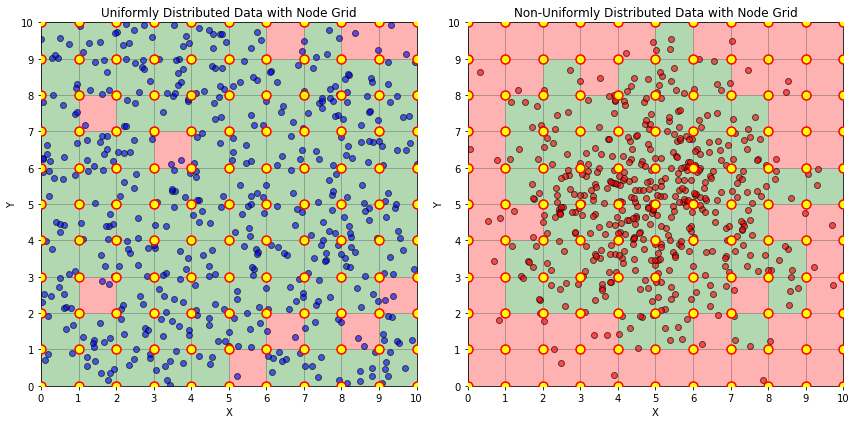

Uniformly Distributed Data passed density standards
Non-uniformly Distributed Data failed density standards


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

cur_folder = os.path.abspath(os.path.curdir)

# Define the number of bins in x and y direction
n_bins = 10

# Load datasets from CSV files
data_path = os.path.join(cur_folder,'mydata', "uniform_data.csv")
uniform_data = pd.read_csv(data_path)

data_path = os.path.join(cur_folder,'mydata', "nonuniform_data.csv")
nonuniform_data = pd.read_csv(data_path)

# Extract X and Y values
x_uniform, y_uniform = uniform_data["X"], uniform_data["Y"]
x_nonuniform, y_nonuniform = nonuniform_data["X"], nonuniform_data["Y"]

# Define grid properties
grid_size = 1  # 1x1 grid cells
x_bins = np.arange(0, n_bins+1, grid_size)  # Bins from 0 to 10
y_bins = np.arange(0, n_bins+1, grid_size)

# Function to count points in each grid cell
def count_points_in_grid(x, y, x_bins, y_bins):
    heatmap, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])
    return heatmap.T  # Transpose to align correctly with the plot

# Count points in grid cells for both datasets
heatmap_uniform = count_points_in_grid(x_uniform, y_uniform, x_bins, y_bins)
heatmap_nonuniform = count_points_in_grid(x_nonuniform, y_nonuniform, x_bins, y_bins)

# Function to configure subplot appearance and overlay grid + nodes
def configure_subplot(ax, title, heatmap, points_per_bin):
    ax.set_title(title)
    ax.set_xlim(0, n_bins)
    ax.set_ylim(0, n_bins)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xticks(x_bins)
    ax.set_yticks(y_bins)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  # Grid lines

    # Overlay colored grid cells based on data density
    for i in range(len(x_bins) - 1):
        for j in range(len(y_bins) - 1):
            color = "green" if heatmap[j, i] >= points_per_bin else "red"  # Green if ≥ points_per_bin, else Red
            ax.add_patch(plt.Rectangle((x_bins[i], y_bins[j]), grid_size, grid_size, 
                                       facecolor=color, alpha=0.3, edgecolor="black", linewidth=0.5))

    # Plot node grid as red circles with yellow filling
    for x_coord in x_bins:
        for y_coord in y_bins:
            ax.scatter(x_coord, y_coord, color="yellow", edgecolors="red", s=80, linewidth=1.5, zorder=3)

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot uniform data
axes[0].scatter(x_uniform, y_uniform, c='blue', edgecolors='black', alpha=0.6, zorder=2)
configure_subplot(axes[0], "Uniformly Distributed Data with Node Grid", heatmap_uniform, points_per_bin)

# Plot non-uniform data
axes[1].scatter(x_nonuniform, y_nonuniform, c='red', edgecolors='black', alpha=0.6, zorder=2)
configure_subplot(axes[1], "Non-Uniformly Distributed Data with Node Grid", heatmap_nonuniform, points_per_bin)

# Show the plot
plt.tight_layout()
plt.show()
plt.show()

# Let the user know whether the density requirement has been met

if sum(heatmap_uniform.flatten() < points_per_bin) <= (100-percentage)/100*n_bins**2/100*n_bins**2:
    print('Uniformly Distributed Data passed density standards')
else:
    print('Uniformly Distributed Data failed density standards')
    
if sum(heatmap_nonuniform.flatten() < points_per_bin) <= (100-percentage)/100*n_bins**2/100*n_bins**2:
    print('Non-Uniformly Distributed Data passed density standards')
else:
    print('Non-uniformly Distributed Data failed density standards')

The figure above shows the data cells that pass the sampling density criterion in green, and those that fail in red. In the case of `points_per_bin = 3` and `percentage=10` 10 of the 100 cells in the uniformly distributed data set fail, making that 90% of the cells meet the defined criterion to be acceptable for gridding; this, only just, meets the criterion for `percentage=10` criterion for accepting the grid. It should be noted that it is possible to accept a subset of the grid - this is common practice in ocean mapping.

___
<img align="left" width="6%" style="padding-right:10px;" src="images/test.png">
Select your own criteria by editing the values in the code cell above the image - then redraw the image by first executing that code cell by selecting it and hitting shift+enter and then selecting the image and hitting shift+enter again.
<br>

____

It may be noted that this manner of creating a criterion is not necessarily the most appropriate as the data at the node is typically derived from data in multiple grid cells surrounding the node. 

In [6]:
import numpy as np
import os

capture_node = (9, 2)  # Node at location of interest
capture_distance = 1.5  # Radius within which points are highlighted

# Previously discussed parameters
# Grid cell acceptance criteria
points_per_bin = 3
percentage = 90

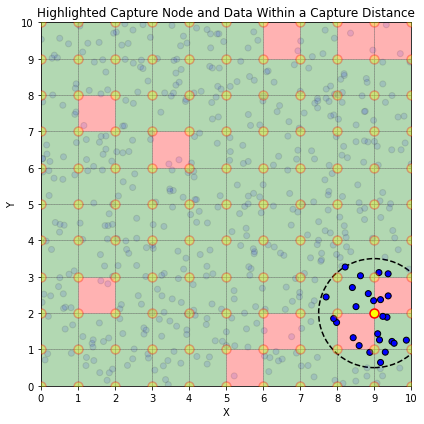

In [9]:
# Define the number of bins in x and y direction
n_bins = 10

# Load datasets from CSV files
cur_folder = os.path.abspath(os.path.curdir)
data_path = os.path.join(cur_folder,'mydata', "uniform_data.csv")
uniform_data = pd.read_csv(data_path)

x_uniform, y_uniform = uniform_data["X"], uniform_data["Y"]

# Define grid properties
grid_size = 1  # 1x1 grid cells
x_bins = np.arange(0, n_bins+1, grid_size)  # Bins from 0 to n_bins
y_bins = np.arange(0, n_bins+1, grid_size)

# Define highlight range and node visibility
# capture_node = np.array([4, 4])  # Node at location of interest
# capture_distance = 3  # Radius within which points are highlighted

# Compute distances of each point from the capture point
distances = np.sqrt((x_uniform - capture_node[0])**2 + (y_uniform - capture_node[1])**2)

# Define alpha values: 1 for points within the range, 0.1 for others
alpha_values = np.where(distances <= capture_distance, 1, 0.1)

# Function to count points in each grid cell
def count_points_in_grid(x, y, x_bins, y_bins):
    heatmap, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])
    return heatmap.T  # Transpose to align correctly with the plot

# Count points in grid cells
heatmap_uniform = count_points_in_grid(x_uniform, y_uniform, x_bins, y_bins)

# Create figure and subplot
fig, ax = plt.subplots(figsize=(6, 6))

# Configure subplot appearance
ax.set_title("Highlighted Capture Node and Data Within a Capture Distance")
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xticks(x_bins)
ax.set_yticks(y_bins)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  # Grid lines

# Overlay colored grid cells based on data density
for i in range(len(x_bins) - 1):
    for j in range(len(y_bins) - 1):
        color = "green" if heatmap_uniform[j, i] >= points_per_bin else "red"  # Green if ≥  points, else Red
        ax.add_patch(plt.Rectangle((x_bins[i], y_bins[j]), grid_size, grid_size, 
                                   facecolor=color, alpha=0.3, edgecolor="black", linewidth=0.5))

# Scatter plot with variable alpha based on distance
ax.scatter(x_uniform, y_uniform, c='blue', edgecolors='black', alpha=alpha_values, zorder=2)

# Plot node grid as red circles with yellow filling, with alpha variation
for x_coord in x_bins:
    for y_coord in y_bins:
        node_alpha = 1 if (x_coord, y_coord) == tuple(capture_node) else 0.3  # Highlight (4,4), dim others
        ax.scatter(x_coord, y_coord, color="yellow", edgecolors="red", s=80, linewidth=1.5, alpha=node_alpha, zorder=3)

# Draw a circle with radius 3 centered at capture_node
circle = plt.Circle(tuple(capture_node), capture_distance, color='black', fill=False, linewidth=1.5, linestyle="--")
ax.add_patch(circle)

# Show the plot
plt.tight_layout()
plt.show()

In the figure above the highlighted data points are within a capture distance from a selected code cell. This illustrates the idea that not only data points within a cell contribute to a node. It could very well be that a node associated to a data cell that fails the test has enough data available to it to make a statistically sound estimate. The node located at (9,2) is an example of a node that has two associated cells that fail our simple coverage criterion, but arguably has a significant number of contributors.

___
<img align="left" width="6%" style="padding-right:10px;" src="images/test.png">
Select a different node and capture distance by editing the code cell above the image - then redraw the image by first executing the code cell by clicking on it and hitting shift+enter and then clicking the image and hitting shift+enter
<br>

____

When you think about it, you probably realize that the points further away should not contribute as much as the points closer by. This is where the concept of inverse distance weighing comes into play. The farther a point is away from a node the less it should contribute to that node. The question that then needs to be addressed is how the distance influence should be modeled.

---
# Inverse Distance Weighting Model Choice

There are many signal processing considerations that apply to the choice of a weighting model in Inverse Distance Weighted gridding. In the interest of limiting the scope of this notebook we will initially focus on the most common choice which is a power model. 

In **Inverse Distance Weighting (IDW)** algorithms used for DEM gridding, the distance is typically squared (or raised to some power, typically between 1 and 3) i.e.:

$$w_i = \frac{1}{d_i^p}$$

where:
$w_i$: Statistical weight of data point $i$<br>
$d_i$: Distance from grid data point to data point $i$<br>
$p \in [1,3] \subset \mathbb{R}$: power parameter

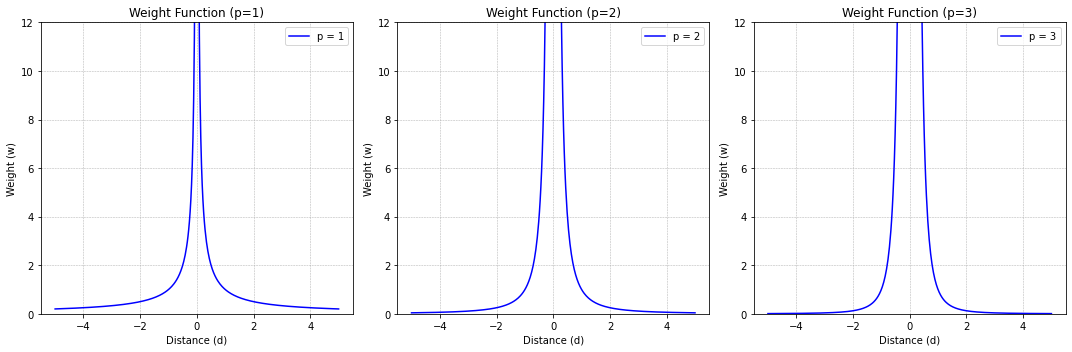

In [354]:
import numpy as np
import matplotlib.pyplot as plt

# Define the distance range (excluding zero to avoid division by zero)
d = np.linspace(-5, 5, 400)
d = d[d != 0]  # Exclude d = 0 to prevent division by zero

# Define p values
p_values = [1, 2, 3]

# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the p values and plot
for i, p in enumerate(p_values):
    w = 1/(np.abs(d) ** p)  # Compute weights
    axes[i].plot(d, w, color="blue", label=f"p = {p}")
    axes[i].set_title(f"Weight Function (p={p})")
    axes[i].set_xlabel("Distance (d)")
    axes[i].set_ylabel("Weight (w)")
    axes[i].set_ylim(0, 12)  # Keep the y-axis range consistent
    axes[i].legend()
    axes[i].grid(True, linestyle="--", linewidth=0.5)
# Show the plot
plt.tight_layout()
plt.show()

In the image above you see the weight functions. All of these lead to data points further away to be weighed less, which is desired. However, weights of the points closed to the point will start approaching infinity. If we assume that the observation has no error this is desired behavior, *but* in this case a TIN will be a more appropriate choice. 

However, data contains observation errors so we do not want to put infinite weight on an observation that happens to coincide with the node's location. If we want to weigh by distance it then makes sense to create weights between 0 (no weight) and 1 (full weight). This may be achieved by amending the IDW formula to:

$$w_i = \frac{1}{d_i^p+1}$$


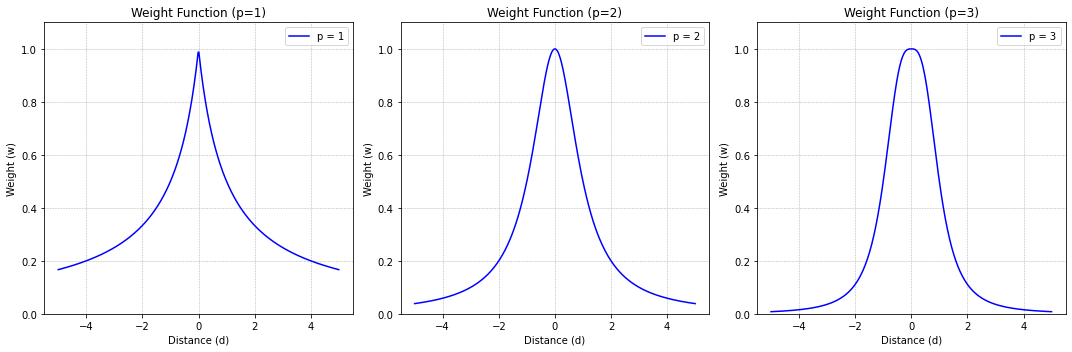

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define the distance range (excluding zero to avoid division by zero)
d = np.linspace(-5, 5, 400)

# Define p values
p_values = [1, 2, 3]

# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the p values and plot
for i, p in enumerate(p_values):
    w = 1/((np.abs(d) ** p)+1)  # Compute weights
    axes[i].plot(d, w, color="blue", label=f"p = {p}")
    axes[i].set_title(f"Weight Function (p={p})")
    axes[i].set_xlabel("Distance (d)")
    axes[i].set_ylabel("Weight (w)")
    axes[i].set_ylim(0, 1.1)  # Keep the y-axis range consistent
    axes[i].legend()
    axes[i].grid(True, linestyle="--", linewidth=0.5)
# Show the plot
plt.tight_layout()
plt.show()

We will use this equation for $w_i$ in the IDW until further notice.

## Inverse Distance Weighting Power Factor Choice

all power factors greater than one will achieve our desired behavior of closer points being more strongly weighted. If we want to have the close points exert a lot of influence we refer to it as having high **local control**, this is introduced by higher values of the power factor $p$ and may lead to the introduction of overly sharp transitions. If we, on the contrary, want a **smooth surface** we need to use lower power factors $p$, which may lead to loss of detail resulting in a blurry DEM.

There are a number of arguments why choosing $p=2$ leads to a good balance between **local control** and a **smooth surface**. In more statistical terms using squared distance **reduces the variance** in the interpolated surface by limiting the effect of distant points, which tend to have **higher variability** in elevation. Without squaring, distant points would contribute more equally, potentially introducing **high-frequency noise** or **unwanted undulations** in the DEM. Squaring then **stabilizes local variations**, making the **interpolated surface more representative** of the true terrain. 

Another way of looking at is that a fixed distance $d_i$ from a grid data point is represented by a circle of radius $d_i$  centered on that point - the area of that circle is given by:

$$ A=2\pi d_i^2$$

where:
$A$: Area of circle of radius $d_i$

Thus the area of the circle grows quadratically with the distance from the data point. If we consider each the data point to represent a fraction of the area within the circle $d_i$ then the fraction of the area drops quadratically with distance. This is the same reason that many physical phenomena such as **gravity, electromagnetic fields**  decay quadratically with distance, which suggests that $p=2$ is an appropriate weighting power factor choice.

Note that the choice $p=1$ leads to a discontinuity.

Conclusion: If we assume that depths are normally distributed, generally a power factor of 2 is the most appropriate


| Power Factor                   |  $p \in [1,2) \subset \mathbb{R}$               |          $P=2$                         | $p >2 \subset \mathbb{R} $ |
|--------------------------------|:------------------------------------------------|:------------------------------|:--------------------------------------------:|
| **Best For**                   \|| sand and finer grain size sediment areas        \|| General Purpose               \||             Rocky areas                                 :| 

____

In [86]:
# Define distance weighting power factor 
# 1 for inverse distance
# 2 for inverse distance squared
# 3 for inverse distance cubed)
p = 1

# Select a node to analyze
capture_node = (2, 7)

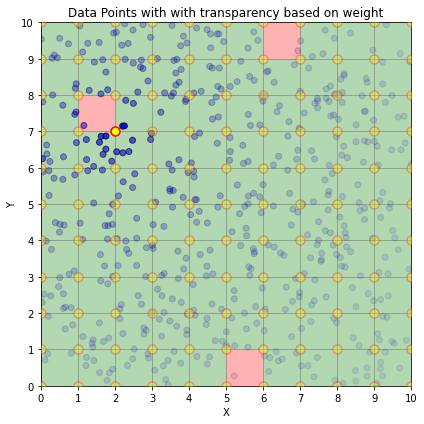

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the number of bins in x and y direction
n_bins = 10

# Load datasets from CSV files
cur_folder = os.path.abspath(os.path.curdir)
data_path = os.path.join(cur_folder,'mydata', "uniform_data.csv")
uniform_data = pd.read_csv(data_path)

x_uniform, y_uniform = uniform_data["X"], uniform_data["Y"]

# Define grid properties
grid_size = 1  # 1x1 grid cells
x_bins = np.arange(0, n_bins + 1, grid_size)  # Bins from 0 to n_bins
y_bins = np.arange(0, n_bins + 1, grid_size)

# Compute weighted inverse distance for alpha values (avoid division by zero)
distances = np.sqrt((x_uniform - capture_node[0])**2 + (y_uniform - capture_node[1])**2)
alpha_values = 1 / ((distances**p)+1)  # Using power p to adjust weighting

# Function to count points in each grid cell
def count_points_in_grid(x, y, x_bins, y_bins):
    heatmap, _, _ = np.histogram2d(x, y, bins=[x_bins, y_bins])
    return heatmap.T  # Transpose to align correctly with the plot

# Count points in grid cells
heatmap_uniform = count_points_in_grid(x_uniform, y_uniform, x_bins, y_bins)

# Define threshold for coloring grid cells
points_per_bin = 2  # Threshold for green/red coloring

# Create figure and subplot
fig, ax = plt.subplots(figsize=(6, 6))

# Configure subplot appearance
ax.set_title(f"Data Points with with transparency based on weight")
ax.set_xlim(0, n_bins)
ax.set_ylim(0, n_bins)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xticks(x_bins)
ax.set_yticks(y_bins)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  # Grid lines

# Overlay colored grid cells based on data density
for i in range(len(x_bins) - 1):
    for j in range(len(y_bins) - 1):
        color = "green" if heatmap_uniform[j, i] >= points_per_bin else "red"  # Green if ≥ threshold, else Red
        ax.add_patch(plt.Rectangle((x_bins[i], y_bins[j]), grid_size, grid_size, 
                                   facecolor=color, alpha=0.3, edgecolor="black", linewidth=0.5))

# Scatter plot with variable alpha based on weighted inverse distance
ax.scatter(x_uniform, y_uniform, c='blue', edgecolors='black', alpha=alpha_values, zorder=2)

# Plot node grid as red circles with yellow filling, with alpha variation
for x_coord in x_bins:
    for y_coord in y_bins:
        node_alpha = 1 if (x_coord, y_coord) == tuple(capture_node) else 0.3  # Highlight capture_node, dim others
        ax.scatter(x_coord, y_coord, color="yellow", edgecolors="red", s=80, linewidth=1.5, alpha=node_alpha, zorder=3)

# Show the plot
plt.tight_layout()
plt.show()

The figure above illustrates the principle of inverse distance weighting and also illustrates the issue with evaluating the validity of a grid cell based on the count of observations within. Though it does identify locations with low spatial coverage, it does not indicate well how strong the statistical estimate at the nodes is.

___
<img align="left" width="6%" style="padding-right:10px;" src="images/test.png">

Select a different `capture_node` and power factor `p` of `1`, `2` or `3` by editing the code cell above the image - then redraw the image by first executing the code cell by clicking on it and hitting shift+enter and then clicking the image and hitting shift+enter
<br>

____

By playing with the selected capture_node and power factor you will find that the amount points contribute is dependent on their distance from the current node, as well as the power factor. It becomes clear that we can take a different approach to the evaluation to the validity of a gridded data set. We could, for example, replace the criterion for number of observations per cell to the sum of all the weights associated to each cell node to exceeding a preset threshold.




In [88]:
# Define distance weighting power factor 
# 1 for inverse distance
# 2 for inverse distance squared
# 3 for inverse distance cubed)
p = 3

# Define a weight threshold between 20 and 40
weight_threshold = 30

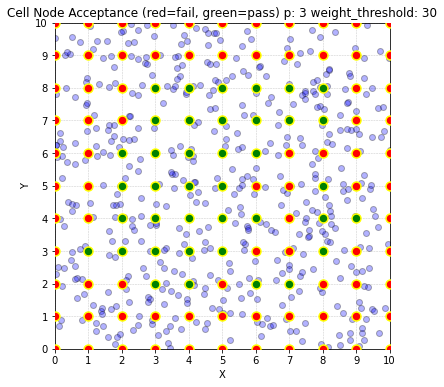

In [89]:
import numpy as np
import pandas as pd
import os

# Define the number of bins in x and y direction
n_bins = 10

# Load datasets from CSV files
cur_folder = os.path.abspath(os.path.curdir)
data_path = os.path.join(cur_folder,'mydata', "uniform_data.csv")
uniform_data = pd.read_csv(data_path)

x_uniform, y_uniform = uniform_data["X"], uniform_data["Y"]

x_bins = np.arange(0, n_bins + 1, grid_size)
y_bins = np.arange(0, n_bins + 1, grid_size)
grid_x_nodes, grid_y_nodes = np.meshgrid(x_bins, y_bins)
grid_x_nodes = grid_x_nodes.ravel()
grid_y_nodes = grid_y_nodes.ravel()

# ### **Compute Sum of Weights for Each Data Point to All Grid Nodes**
sum_weights_data = np.zeros(len(grid_x_nodes))  # Initialize sum of weights for each data point

for i in range(len(x_uniform)):
    # Compute distances from each data node to the current data point
    distances = np.sqrt((grid_x_nodes- x_uniform[i])**2 + (grid_y_nodes-y_uniform[i])**2)
    
    # Compute weights using inverse distance or inverse distance squared
    # Offset them by one so that the weigth for the grid node itself is one
    weights = 1 / ((distances**p)+1)
    
    # Sum the weights for each data point
    sum_weights_data += weights

# Store results for grid nodes
sum_weights_data_df = pd.DataFrame({
    'X': grid_x_nodes,
    'Y': grid_y_nodes,
    'Sum_Weights': sum_weights_data
})

sum_weights_data.resize(n_bins+1,n_bins+1)

# Create figure and subplot
fig, ax = plt.subplots(figsize=(6, 6))

# Configure subplot appearance
ax.set_title(f"Cell Node Acceptance (red=fail, green=pass) p: {p} weight_threshold: {weight_threshold}")
ax.set_xlim(0, n_bins)
ax.set_ylim(0, n_bins)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xticks(x_bins)
ax.set_yticks(y_bins)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  # Grid lines


# Scatter plot with a constant alpha value
ax.scatter(x_uniform, y_uniform, c='blue', edgecolors='black', alpha=0.3, zorder=2)

# Plot node grid as yellow circles with red or green filling
for x_coord in x_bins:
    for y_coord in y_bins:
        fill_color = "red" if sum_weights_data[x_coord, y_coord] <= weight_threshold else "green"  # red if fail, green if pass

        ax.scatter(x_coord, y_coord, color=fill_color, edgecolors="yellow", s=80, linewidth=1.5, alpha=1, zorder=3)
        


In the figure above a grid node center is shown in green if the combined weight of the data points contributing to it exceeds the value set in the variable `weight_threshold` - if it does not the grid node center turns red. 

___
<img align="left" width="6%" style="padding-right:10px;" src="images/test.png">

Try each of `p` values `1`,`2`, and `3` with `weight_threshold` values `20`, `30`, and `40` 
<br>

What do you notice about the node acceptance as a function of the value of `p`?

____

That the nodes fail faster at higher values of the power factor $p$ should come as no surprise as the influence of the data is felt over shorter distances.


A problem that occurs with using the accumulated weight for a grid node is that it is not easy to imagine what this means for data quality. A simple count or a standard deviation in depth would be easier. A count does not work as all the data points contribute to each cell node, which raises another issue: **efficiency**

By playing with the selected power factor you will find that the amount points contribute as a function of distance is strongly dependent on the value of `p`. In this case there is only 500 data points and 121 cell nodes in the data set and grid respectively, meaning that we only have to calculate 60,500 distances to evaluate all distances to all data points - a minor task for modern computers. However, a typical bathymetry data set may have millions of data points and nodes leading to trillions of distance computations. Clearly this is a numerical challenge, even for modern computers.

To reduce the number of calculations it therefore makes sense to restrict the sphere of influence of data points. Let's analyze the effect by creating two DEMs from a data set containing elevation data

First we will introduce this data and say something about the importance of how the data is visually represented.

____

___

## The Importance of Proper Data Visualization and the Role of a DEM as a Surface

for the next bit it is useful to use a point cloud of data that represents a well understood shape, so that it is easy to analyze the result of your choices. We will progressively introduce other data as we will highlight further features. Below are two visualizations of the same point cloud.


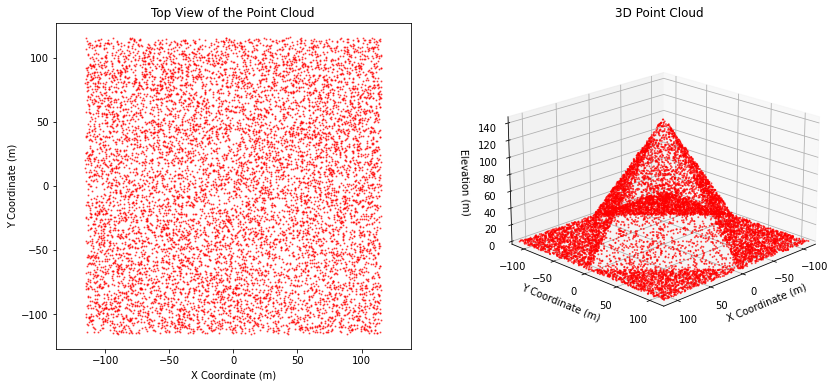

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Load the point cloud data

# Load datasets from CSV files
cur_folder = os.path.abspath(os.path.curdir)
data_path = os.path.join(cur_folder,'mydata', "pyramid_noisy_point_cloud.csv")
point_cloud = pd.read_csv(data_path)

# Extract X, Y, and Z coordinates
x = point_cloud["X"].values
y = point_cloud["Y"].values
z = point_cloud["Z"].values

# Create a figure with two subplots (3D on the left, 2D top view on the right)
fig = plt.figure(figsize=(14, 6))

# 3D Point Cloud Visualization (Right Subplot)
ax1 = fig.add_subplot(122, projection='3d')
sc1 = ax1.scatter(x, y, z, c="red", s=1, alpha=0.6)
ax1.set_xlabel("X Coordinate (m)")
ax1.set_ylabel("Y Coordinate (m)")
ax1.set_zlabel("Elevation (m)")
ax1.set_title("3D Point Cloud")
ax1.view_init(elev=20, azim=45)  # Set 3D viewing angle

# **✅ Fix unwanted 0.0 to 1.0 outer subplot axes**
ax1.set_proj_type('persp')  # Enforce perspective projection (prevents auto-scaling)
ax1.set_box_aspect([1,1, max(z)/(max(x)-min(x))])  # Ensure equal aspect ratio for 3D space
ax1.set_xlim([min(x), max(x)])
ax1.set_ylim([min(y), max(y)])
ax1.set_zlim([min(z), max(z)])

# 2D Top View (Left Subplot)
ax2 = fig.add_subplot(121)
sc2 = ax2.scatter(x, y, c="red", s=1, alpha=0.6)
ax2.set_xlabel("X Coordinate (m)")
ax2.set_ylabel("Y Coordinate (m)")
ax2.set_title("Top View of the Point Cloud")
ax2.axis("equal")  # Ensure equal scaling for X and Y axes

# Show the figure
plt.show()



In the figure above you see two visualizations of data in the same point cloud. This highlights that visualizing a point cloud in 2-D without a color map as shown on the left only gives you information about the distribution of the points but it is impossible to interpret the **morphology** or shape that the data represents. The 3-D display on the right helps a great deal, most people will recognize the shape as a pyramid - the data is, as matter of fact, a point cloud representing the Pyramid of Giza - though there is far too little detail for human cognition to easily recognize it as representing that. Let's explore whether using color helps:


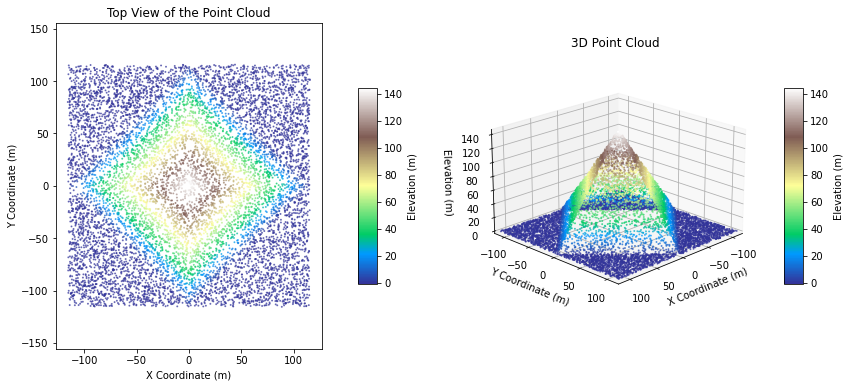

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Load the point cloud data

# Load datasets from CSV files
cur_folder = os.path.abspath(os.path.curdir)
data_path = os.path.join(cur_folder,'mydata', "pyramid_noisy_point_cloud.csv")
point_cloud = pd.read_csv(data_path)

# Extract X, Y, and Z coordinates
x = point_cloud["X"].values
y = point_cloud["Y"].values
z = point_cloud["Z"].values

# Create a figure with two subplots (3D on the left, 2D top view on the right)
fig = plt.figure(figsize=(14, 6))

# 3D Point Cloud Visualization (Right Subplot)
ax1 = fig.add_subplot(122, projection='3d')
sc1 = ax1.scatter(x, y, z, c=z, cmap="terrain", s=1, alpha=0.6)
ax1.set_xlabel("X Coordinate (m)")
ax1.set_ylabel("Y Coordinate (m)")
ax1.set_zlabel("Elevation (m)")
ax1.set_title("3D Point Cloud")
ax1.view_init(elev=20, azim=45)  # Set 3D viewing angle

# **✅ Fix unwanted 0.0 to 1.0 outer subplot axes**
ax1.set_proj_type('persp')  # Enforce perspective projection (prevents auto-scaling)
ax1.set_box_aspect([1,1, max(z)/(max(x)-min(x))])  # Ensure equal aspect ratio for 3D space
ax1.set_xlim([min(x), max(x)])
ax1.set_ylim([min(y), max(y)])
ax1.set_zlim([min(z), max(z)])

# Add colorbar for 3D plot
cbar1 = plt.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=min(z), vmax=max(z)), cmap="terrain"), ax=ax1, shrink=0.6, aspect=10, pad=0.1)
cbar1.set_label("Elevation (m)")

# 2D Top View (Left Subplot)
ax2 = fig.add_subplot(121)
sc2 = ax2.scatter(x, y, c=z, cmap="terrain", s=1, alpha=0.6)
ax2.set_xlabel("X Coordinate (m)")
ax2.set_ylabel("Y Coordinate (m)")
ax2.set_title("Top View of the Point Cloud")
ax2.axis("equal")  # Ensure equal scaling for X and Y axes

# Add colorbar for 2D plot
cbar2 = plt.colorbar(cm.ScalarMappable(norm=mcolors.Normalize(vmin=min(z), vmax=max(z)), cmap="terrain"), ax=ax2, shrink=0.6, aspect=10, pad=0.1)
cbar2.set_label("Elevation (m)")

# Show the figure
plt.show()



Adding color helped a great deal with the interpretation of the 2D view, but only contributes in a limited fashion to the 3 dimensional view. The figure above highlights that using a color map as shown on the left is still a poor choice, unless you have a lot of experience and insight is hard to interpret the data, even with the help of the legend. For the 3-D display the color coding only helps the interpretation marginally.

Note that in reality the point cloud would probably be even harder to interpret, as there can be significant noise present in the observations. An even better way of representing the pyramid would be using a continuous surface, as that how we perceive reality with our brain.

In [68]:
# Set viewing angle for better visualization
view_azimuth=45# View direction in degrees 
view_elevation=25 # View elevation in degrees

# Define grid resolution
num_grid_points = 300  # Adjust for resolution - Keep it in the range [1,300]

# Define distance weighting power factor
p = 3

k = 20

# Apply vertical exaggeration
vertical_exaggeration = 1

# ----- USER CHOICE: Select Coloring Mode -----
color_mode = "sandy_hillshade"  # Choose: "sandy_hillshade", or "elevation"

# Set parameters for hillshading - only works if color_by_elevation = False
sun_azimuth = 45  # Sun direction in degrees (0 = North, 90 = East)
sun_elevation = 25  # Sun elevation angle in degrees

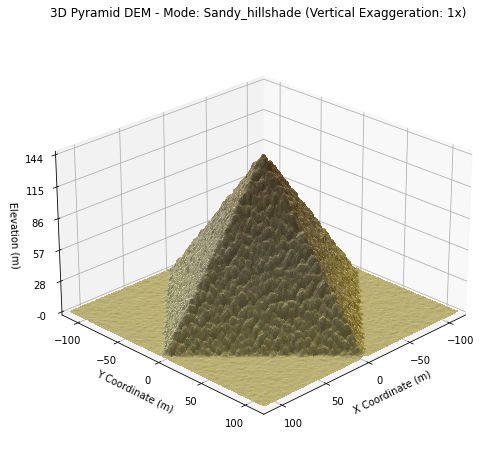

In [69]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from matplotlib.colors import LightSource, Normalize, LinearSegmentedColormap
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import timeit

# Load datasets from CSV files
cur_folder = os.path.abspath(os.path.curdir)
data_path = os.path.join(cur_folder,'mydata', "pyramid_noisy_point_cloud.csv")

# Load the DEM data from the CSV file
dem_data = pd.read_csv(data_path)

# Extract X, Y, and Z values
x = dem_data["X"].values
y = dem_data["Y"].values
z = dem_data["Z"].values

# Create a structured grid
grid_x, grid_y = np.meshgrid(
    np.linspace(min(x), max(x), num_grid_points),
    np.linspace(min(y), max(y), num_grid_points)
)

# ----- Inverse Distance Weighting (IDW) Function -----
def idw_interpolation(x, y, z, grid_x, grid_y, power=2, k=8):
    """Performs Inverse Distance Weighting (IDW) interpolation."""
    tree = cKDTree(np.column_stack([x, y]))
    grid_shape = grid_x.shape
    grid_x_flat, grid_y_flat = grid_x.ravel(), grid_y.ravel()
    distances, indices = tree.query(np.column_stack([grid_x_flat, grid_y_flat]), k=8)  # k nearest points

    
    # Compute IDW weights
    weights = 1 / ((distances ** power)+1)
    weights /= weights.sum(axis=1, keepdims=True)  # Normalize weights

    # Compute interpolated values
    interpolated_z = np.sum(weights * z[indices], axis=1)
    return interpolated_z.reshape(grid_shape)

# Apply IDW interpolation
grid_z_original = idw_interpolation(x, y, z, grid_x, grid_y, p, k)

# Apply vertical exaggeration
grid_z_exaggerated = grid_z_original * vertical_exaggeration  # Scale for visualization

# Create a light source
ls = LightSource(azdeg=sun_azimuth, altdeg=sun_elevation)

# ----- Custom "Sandy Yellow" Colormap -----
sandy_colormap = LinearSegmentedColormap.from_list("sandy", ["#EEDC82", "#C2B280", "#A68B5B"], N=256)

# Normalize elevation values for colormap
norm = Normalize(vmin=np.nanmin(grid_z_original), vmax=np.nanmax(grid_z_original))

# Apply sandy and terrain colormaps
sandy_colors = sandy_colormap(norm(grid_z_original))
terrain_colors = cm.terrain(norm(grid_z_original))

# Apply hillshading
hillshade_sandy = ls.shade(grid_z_exaggerated, cmap=sandy_colormap, blend_mode="soft", vert_exag=vertical_exaggeration)
hillshade_terrain = ls.shade(grid_z_exaggerated, cmap=cm.terrain, blend_mode="soft", vert_exag=vertical_exaggeration)

# Determine which color scheme to use
if color_mode == "sandy":
    colors = sandy_colors
elif color_mode == "sandy_hillshade":
    colors = hillshade_sandy
elif color_mode == "elevation":
    colors = hillshade_terrain  # Terrain-colored hillshade
else:
    raise ValueError("Invalid color_mode. Choose 'sandy', 'sandy_hillshade', or 'elevation'.")

# Create the figure and 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the surface
ax.plot_surface(grid_x, grid_y, grid_z_exaggerated, facecolors=colors, rstride=1, cstride=1, linewidth=0, antialiased=False)

# Fix Z-axis labels to show original elevation values
z_ticks_exaggerated = np.linspace(grid_z_exaggerated.min(), grid_z_exaggerated.max(), num=6)  # Tick positions
z_tick_labels = np.linspace(grid_z_original.min(), grid_z_original.max(), num=6)  # True elevation values
ax.set_zticks(z_ticks_exaggerated)
ax.set_zticklabels([f"{val:.0f}" for val in z_tick_labels])  # Convert to integer labels

# Force vertical exaggeration to be visible by adjusting axis limits
x_range = max(x) - min(x)
y_range = max(y) - min(y)
z_range = (grid_z_exaggerated.max() - grid_z_exaggerated.min()) / vertical_exaggeration  # True z range

ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))
ax.set_zlim(grid_z_exaggerated.min(), grid_z_exaggerated.max())  # Ensures vertical exaggeration shows correctly

# Set aspect ratio manually to enhance vertical exaggeration
ax.set_box_aspect([x_range, y_range, z_range * vertical_exaggeration])

# Labels and title
ax.set_xlabel("X Coordinate (m)")
ax.set_ylabel("Y Coordinate (m)")
ax.set_zlabel("Elevation (m)")
ax.set_title(f"3D Pyramid DEM - Mode: {color_mode.capitalize()} (Vertical Exaggeration: {vertical_exaggeration}x)")

# Set viewing angle for better visualization
ax.view_init(elev=view_elevation, azim=view_azimuth)
# Show the figure
plt.show()

In the figure above a DEM is calculated from the point data and then visualized as a hill shaded surface.

___
<img align="left" width="6%" style="padding-right:10px;" src="images/test.png">

Try manipulating the visualization of the pyramid by changing the values in the code cell above the image and executing it by `shift+enter`, show the result by clicking on the image and by `shift+enter`.

For the number of grid points it is suggested to try the values of 10, 50, and 200 - Do not exceed 300!
____

Using the hill shade helps a great deal with interpreting the morphology represented by the data - using color to indicate elevation does not help much with the interpretation at all, and actually may lead to confusion. The DEM looks much more like a pyramid when using the `"sandy_hillshade"` colormap as that corresponds to the color that we associate with the Pyramid of Giza. 

It is often helpful to drape an image on the terrain model e.g., a photo of the Pyramid of Giza - a process known as texture mapping This can help a great deal with not just recognizing the morphology, but actual identification of the object. We will not further address this here, but for the programmers among you it is a fun challenge to try and drape an image of a favorite object, pet, or person onto the pyramid.

Note that the combination of view angles and sun angles greatly affects how well we can interpret the hill shaded DEM! Note that with a high `view_elevation` it is possible to reverse our interpretation of high and low by manipulating the `sun_azimuth`. Some data visualization software will allow you to dynamically change the viewing parameters in order to optimize the viewing experience. Unfortunately, jupyter notebooks, such as this one, are not designed to do this efficiently, so we can not demonstrate it here.

Another one of the parameters that we can set in the code cell is that of the number of grid points, what you will notice is that increasing the number of points strongly affects the time it takes to calculate and visualize the DEM. This takes us back to the discussion of how to create DEMs. We will shift away from IDW grids to uncertainty-weighted DEMs

___

# Let's Synthesize Some Data

In order to allow you to more easily understand the concepts lets create a synthetic data set for the next few steps. We will create geodetic data representative of a pyramid of the same size as the Pyramid of Giza with all the necesarry geodetic metadata. However, we will produce this data three times - one where the Pyramid is located in Egypt, the next where it is located in Amsterdam, the Netherlands, and the third where the Pyramids

In [84]:
import os
import numpy as np
import pandas as pd
from pyproj import CRS, Transformer

# --- Output Directory ---
output_dir = "mydata"
os.makedirs(output_dir, exist_ok=True)

# --- Pyramid Parameters ---
base_length = 230.4       # meters (side of square base)
height = 138.8            # meters (current height of the Great Pyramid)
layers = 100              # number of vertical layers
points_per_side = 100     # resolution per side on each layer

# --- Placement Locations (WGS84 coordinates) ---
locations = {
    "giza": {"lat": 29.9792, "lon": 31.1342, "h": 45.0},
    "amsterdam": {"lat": 52.374, "lon": 4.8897, "h": 5.0},
    "nunavut": {"lat": 70.0, "lon": -90.0, "h": 50.0}
}

# --- Coordinate Systems ---
crs_geodetic = CRS("EPSG:4979")  # WGS84: lat, lon, ellipsoidal height
crs_ecef = CRS("EPSG:4978")      # Earth-Centered, Earth-Fixed (ECEF)
to_ecef = Transformer.from_crs(crs_geodetic, crs_ecef, always_xy=True)
from_ecef = Transformer.from_crs(crs_ecef, crs_geodetic, always_xy=True)

# --- ENU to ECEF rotation matrix ---
def enu_to_ecef_matrix(lat, lon):
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    return np.array([
        [-np.sin(lon_rad), -np.sin(lat_rad)*np.cos(lon_rad),  np.cos(lat_rad)*np.cos(lon_rad)],
        [ np.cos(lon_rad), -np.sin(lat_rad)*np.sin(lon_rad),  np.cos(lat_rad)*np.sin(lon_rad)],
        [ 0,                np.cos(lat_rad),                  np.sin(lat_rad)]
    ])

# --- Loop through locations ---
for name, loc in locations.items():
    file_path = os.path.join(output_dir, f"pyramid_point_cloud_{name}.csv")

    if os.path.exists(file_path):
        print(f"✅ File already exists: {file_path}")
        continue

    print(f"⏳ Generating point cloud for: {name.capitalize()}")

    lat0, lon0, h0 = loc["lat"], loc["lon"], loc["h"]
    x0, y0, z0 = to_ecef.transform(lon0, lat0, h0)
    R = enu_to_ecef_matrix(lat0, lon0)

    points = []

    for i in range(layers + 1):
        layer_height = height * (i / layers)
        side_length = base_length * (1 - i / layers)
        half = side_length / 2

        x = np.linspace(-half, half, points_per_side)
        y = np.linspace(-half, half, points_per_side)
        X, Y = np.meshgrid(x, y)
        Z = np.full_like(X, layer_height)

        enu_points = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
        for enu in enu_points:
            ecef = R @ enu + np.array([x0, y0, z0])
            lon, lat, h = from_ecef.transform(*ecef)
            points.append((lat, lon, h0 + enu[2]))

    df = pd.DataFrame(points, columns=["Latitude", "Longitude", "Ellipsoidal_Height"])

    # --- Metadata header ---
    metadata = [
        f"# Synthetic Point Cloud: Pyramid of Giza placed in {name.capitalize()}",
        "# Coordinate Reference System: WGS84 (EPSG:4979)",
        "# Units: Latitude/Longitude in decimal degrees, Height in meters (ellipsoidal)",
        f"# Origin of local ENU: Latitude={lat0}, Longitude={lon0}, Ellipsoidal Height={h0} m",
        "# Columns: Latitude, Longitude, Ellipsoidal_Height"
    ]

    with open(file_path, "w") as f:
        for line in metadata:
            f.write(line + "\n")
        df.to_csv(f, index=False)

    print(f"✅ Saved: {file_path}")

✅ File already exists: mydata/pyramid_point_cloud_giza.csv
✅ File already exists: mydata/pyramid_point_cloud_amsterdam.csv
✅ File already exists: mydata/pyramid_point_cloud_nunavut.csv


The code cell above creates data files to be used in the rest of this notebook - these files are fairly large and cannot be distributed using the system used for distributing this Notebook.

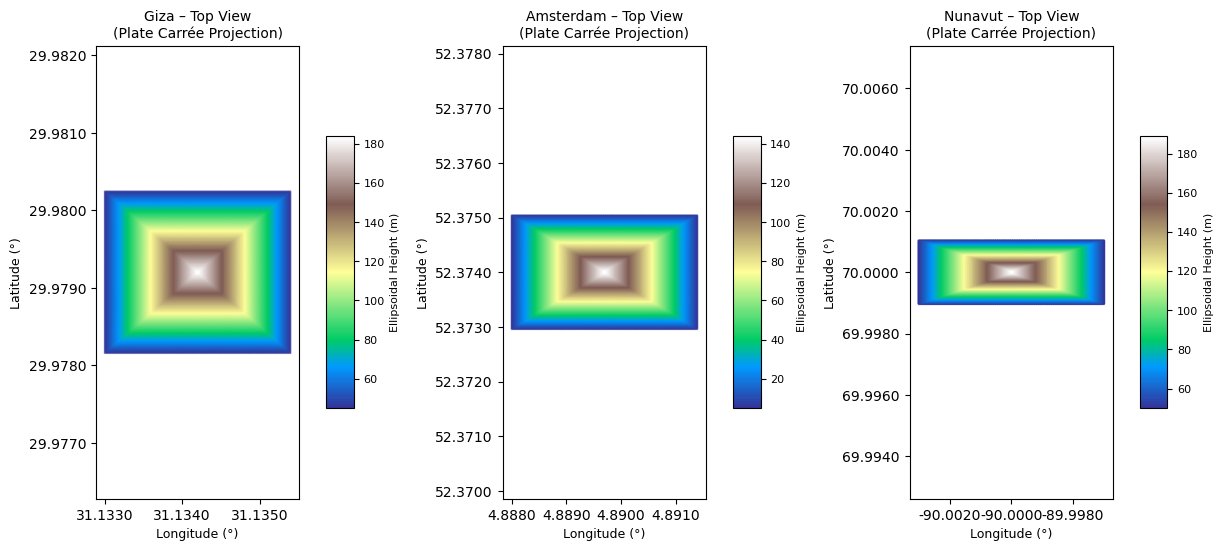

In [85]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter

# --- Load geodetic point cloud (WGS84) ---
cur_folder = os.path.abspath(os.path.curdir)
locations = ("giza", "amsterdam", "nunavut")

# --- Create the figure ---
fig, ax = plt.subplots(1, len(locations), figsize=(14, 6), dpi=100)

for i, loc in enumerate(locations):
    data_path = os.path.join(cur_folder, 'mydata', f"pyramid_point_cloud_{loc.lower()}.csv")
    point_cloud = pd.read_csv(data_path, comment="#")

    # --- Extract geodetic coordinates ---
    lon = point_cloud["Longitude"].values
    lat = point_cloud["Latitude"].values
    height = point_cloud["Ellipsoidal_Height"].values

    # --- Normalize for consistent color mapping ---
    norm = mcolors.Normalize(vmin=np.min(height), vmax=np.max(height))

    # --- Plot 2D plan view ---
    sc = ax[i].scatter(lon, lat, c=height, cmap="terrain", s=1, alpha=0.6, norm=norm)
    ax[i].set_xlabel("Longitude (°)", fontsize=9)
    ax[i].set_ylabel("Latitude (°)", fontsize=9)
    ax[i].set_title(f"{loc.title()} – Top View\n(Plate Carrée Projection)", fontsize=10)
    ax[i].axis("equal")

    # --- Force axis labels to use real numbers ---
    ax[i].xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    ax[i].yaxis.set_major_formatter(FormatStrFormatter('%.4f'))

    # --- Add colorbar ---
    cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap="terrain"), ax=ax[i],
                        shrink=0.6, aspect=10, pad=0.1)
    cbar.set_label("Ellipsoidal Height (m)", fontsize=8)
    cbar.ax.tick_params(labelsize=8)

# --- Adjust layout ---
fig.subplots_adjust(wspace=0.5)

# --- Show the figure ---
plt.show()



The image above illustrates the problem with the Plate Carree projection. Even though the footprint of the pyramid of all three pyramids is identical in shape in all locations this is not obvious from the representation in the maps above.

In [77]:
# --- User Parameters ---
num_grid_points = 100
p = 2
k = 80
vertical_exaggeration = 3.0
sun_azimuth = 315
sun_elevation = 45
color_mode = "sandy_hillshade"  # Options: 'sandy', 'sandy_hillshade', 'elevation'
view_elevation = 45
view_azimuth = -60

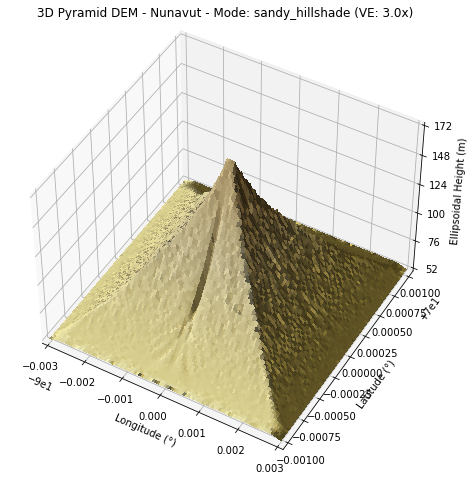

In [75]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from matplotlib.colors import LightSource, Normalize, LinearSegmentedColormap
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

# --- User Selection ---
location = "nunavut"  # Options: "amsterdam", "aarhus", "nunavut"

# Load datasets from CSV files
cur_folder = os.path.abspath(os.path.curdir)
filename = f"pyramid_point_cloud_{location}.csv"
data_path = os.path.join(cur_folder,'mydata', filename)




# --- Load Point Cloud ---
df = pd.read_csv(data_path, comment="#")
lon = df["Longitude"].values
lat = df["Latitude"].values
h = df["Ellipsoidal_Height"].values

# --- Plate Carrée Projection (lon/lat as x/y) ---
x = lon
y = lat
z = h

# --- Create Grid ---
grid_x, grid_y = np.meshgrid(
    np.linspace(min(x), max(x), num_grid_points),
    np.linspace(min(y), max(y), num_grid_points)
)

# --- IDW Interpolation ---
def idw_interpolation(x, y, z, grid_x, grid_y, power=2, k=8):
    tree = cKDTree(np.column_stack([x, y]))
    grid_shape = grid_x.shape
    grid_points = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    distances, indices = tree.query(grid_points, k=k)

    weights = 1 / ((distances ** power)+1)
    weights /= weights.sum(axis=1, keepdims=True)

    interpolated_z = np.sum(weights * z[indices], axis=1)
    return interpolated_z.reshape(grid_shape)

grid_z_original = idw_interpolation(x, y, z, grid_x, grid_y, p, k)
grid_z_exaggerated = grid_z_original * vertical_exaggeration

# --- Lighting and Colormap ---
ls = LightSource(azdeg=sun_azimuth, altdeg=sun_elevation)
sandy_colormap = LinearSegmentedColormap.from_list("sandy", ["#EEDC82", "#C2B280", "#A68B5B"], N=256)
norm = Normalize(vmin=np.nanmin(grid_z_original), vmax=np.nanmax(grid_z_original))

sandy_colors = sandy_colormap(norm(grid_z_original))
terrain_colors = cm.terrain(norm(grid_z_original))

hillshade_sandy = ls.shade(grid_z_exaggerated, cmap=sandy_colormap, blend_mode="soft", vert_exag=vertical_exaggeration)
hillshade_terrain = ls.shade(grid_z_exaggerated, cmap=cm.terrain, blend_mode="soft", vert_exag=vertical_exaggeration)

# --- Choose Color Mode ---
if color_mode == "sandy":
    colors = sandy_colors
elif color_mode == "sandy_hillshade":
    colors = hillshade_sandy
elif color_mode == "elevation":
    colors = hillshade_terrain
else:
    raise ValueError("Invalid color_mode. Choose 'sandy', 'sandy_hillshade', or 'elevation'.")

# --- Plot 3D ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z_exaggerated, facecolors=colors,
                rstride=1, cstride=1, linewidth=0, antialiased=False)

# --- Z-axis Labels ---
z_ticks_exaggerated = np.linspace(grid_z_exaggerated.min(), grid_z_exaggerated.max(), num=6)
z_tick_labels = np.linspace(grid_z_original.min(), grid_z_original.max(), num=6)
ax.set_zticks(z_ticks_exaggerated)
ax.set_zticklabels([f"{val:.0f}" for val in z_tick_labels])

# --- Axis Setup ---
x_range = max(x) - min(x)
y_range = max(y) - min(y)
z_range = (grid_z_exaggerated.max() - grid_z_exaggerated.min()) / vertical_exaggeration

ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))
ax.set_zlim(grid_z_exaggerated.min(), grid_z_exaggerated.max())
# Do not enforce equal aspect ratio, let z scale independently
# ax.set_box_aspect([x_range, y_range, z_range * vertical_exaggeration])

ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
ax.set_zlabel("Ellipsoidal Height (m)")
ax.set_title(f"3D Pyramid DEM - {location.capitalize()} - Mode: {color_mode} (VE: {vertical_exaggeration}x)")

ax.view_init(elev=view_elevation, azim=view_azimuth)
plt.show()

TO DO: Add code cell to give the student chance to map to UTM or Polar stereographic - illustrating why it matters what you choose where

For now - we will look at IDW based on uncertainty using appropriate projection - using data with propagated a-priori uncertainties.

The rest of the notebook is still in development - biggest addition will be discussion of grid cell size with examples and addition of a geodetic data set with propagated uncertainties - essentially the dataset with artificial cones, spheres and cubes from the MB course visualization lectures

# Uncertainty Weighed DEM gridding

In [226]:
point_cloud.head()

,X,Y,Z,Horizontal_Uncertainty,Vertical_Uncertainty
0,35.243769,94.553207,-0.064515,0.846617,0.326258
1,-96.691630,-27.632045,0.410774,0.517882,0.491412
2,35.587247,-99.598086,-0.116958,0.771960,0.459196
3,105.647039,-37.719715,0.151230,0.928051,0.463153
4,84.188427,51.659703,-0.252065,0.562299,0.498834


Above you see the first few data records in the projected Pyramid dataset. Before proceeding, let’s examine the this dataset in a little more detail. First of all, there is no header meta data, this is unfortunate as the only way of portraying it properly is by following a set of assumptions. In this case we will assume that these coordinates are in meters relative to the WGS84 ellipsoid, with the z-component being ellipsoidal height. 

Also, so far, we have assumed that data is error-free, this is an unrealistic scenario. Due to observational errors and instrument limitations, it is virtually impossible for measurements to be entirely accurate. Every observation contains a residual, which is the difference between the measured value and the true value—though the true value is unknowable. However, we can make statistical statements about the properties of these residuals. In the case of this dataset the observation uncertainties have been propagated to represent the total uncertainty of each data point. This is broken up in a positional and a height uncertainty component. It is important to remember that the coordinate reference systems (CRSs) used for horizontal and vertical data may differ, which must be accounted for in the analysis.

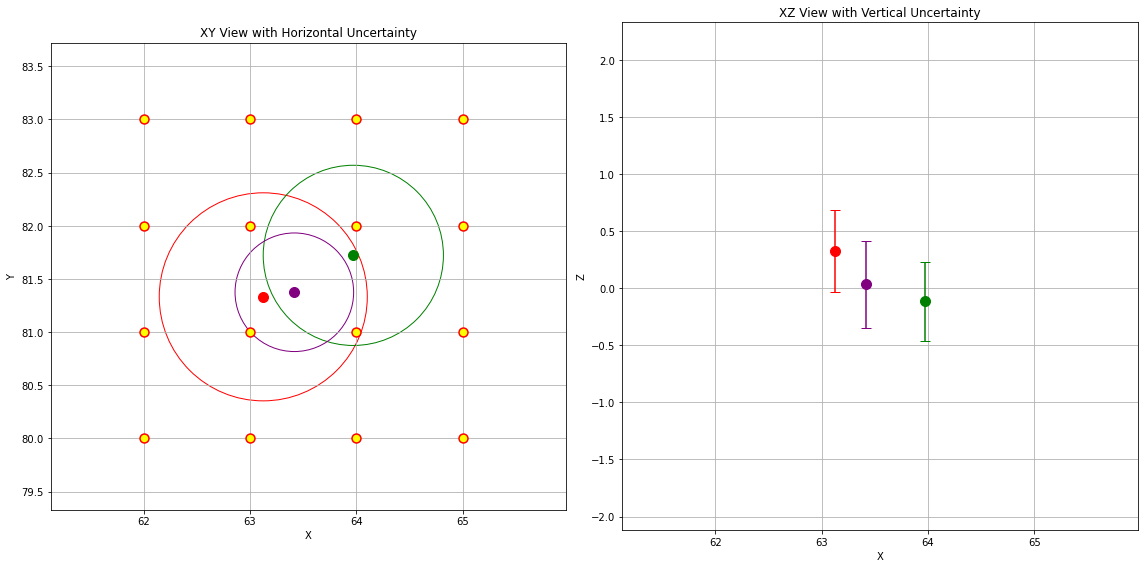

In [227]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Load the CSV data
cur_folder = os.path.abspath(os.path.curdir)
data_path = os.path.join(cur_folder, 'mydata', "pyramid_noisy_point_cloud.csv")
point_cloud_df = pd.read_csv(data_path)

# Group points into grid cells using a coarser grid for efficiency
grid_size = 1.0  # Grid cell size
grid = defaultdict(list)

for idx, row in point_cloud_df.iterrows():
    x_idx = int(row['X'] // grid_size)
    y_idx = int(row['Y'] // grid_size)
    grid[(x_idx, y_idx)].append(idx)

# Find a cell with exactly three points
selected_indices = None
for cell, indices in grid.items():
    if len(indices) == 3:
        selected_indices = indices
        break
        
# Extract the three selected points
selected_df = point_cloud_df.loc[selected_indices]

# Define grid properties
x_bins = np.arange(int(min(selected_df['X']))-1, int(max(selected_df['X']))+3, grid_size)  # Bins from 0 to 10
y_bins = np.arange(int(min(selected_df['Y']))-1, int(max(selected_df['Y']))+3, grid_size)  # Bins from 0 to 10

# Set up the figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

colors = ['red', 'green', 'purple']

# --- Subplot 1: X-Y view with horizontal uncertainty circles ---
ax1 = axs[0]
for i, (_, row) in enumerate(selected_df.iterrows()):
    color = colors[i % len(colors)]
    circle = plt.Circle((row['X'], row['Y']), row['Horizontal_Uncertainty'],
                        edgecolor=color, facecolor='none', linewidth=1)
    ax1.add_patch(circle)
    ax1.plot(row['X'], row['Y'], 'o', color=color, markersize=10)

ax1.set_xlim(selected_df['X'].min() - 2, selected_df['X'].max() + 2)
ax1.set_ylim(selected_df['Y'].min() - 2, selected_df['Y'].max() + 2)
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('XY View with Horizontal Uncertainty')
ax1.grid(True)

for x_coord in x_bins:
    for y_coord in y_bins:
        node_alpha = 1
        ax1.scatter(x_coord, y_coord, color="yellow", edgecolors="red", s=80, linewidth=1.5, alpha=node_alpha, zorder=3)

# --- Subplot 2: X-Z view with vertical uncertainty bars ---
ax2 = axs[1]
for i, (_, row) in enumerate(selected_df.iterrows()):
    color = colors[i % len(colors)]
    ax2.errorbar(row['X'], row['Z'], yerr=row['Vertical_Uncertainty'],
                 fmt='o', color=color, ecolor=color, capsize=5, markersize=10)

ax2.set_xlim(selected_df['X'].min() - 2, selected_df['X'].max() + 2)
ax2.set_ylim(selected_df['Z'].min() - 2, selected_df['Z'].max() + 2)
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_title('XZ View with Vertical Uncertainty')
ax2.grid(True)

plt.tight_layout()
plt.show()


In the cell above you see two views of the same small subset of points in the data sets. The plot on the left shows a top view of the points and their associated horizontal positioning uncertainties visualized as circles centered on the points. Also visualized are the grid nodes as red circles with yellow filling. In the plot on the right the data is shown as elevation data with error bars indicating their uncertainty.

It is pretty clear that we can use the vertical uncertainty as an additional weighting factor to the inverse distance weight factor, but what to do about the horizontal error? In the spirit of IDW gridding we can address this by increasing the nominal distance from the data point to the grid node.

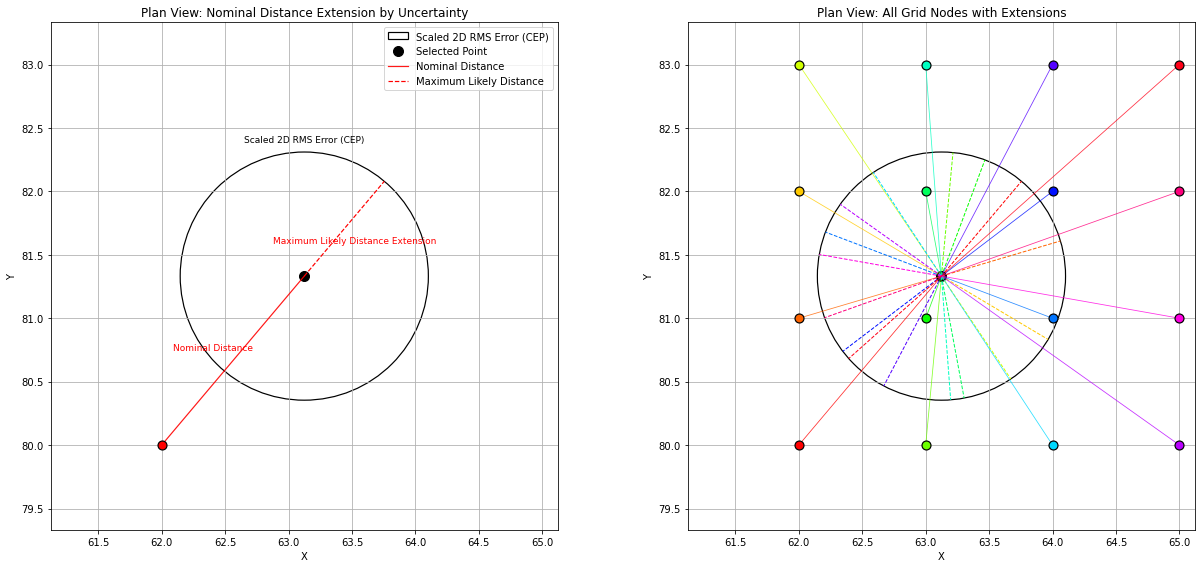

In [228]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import matplotlib.cm as cm

# Load the CSV data
cur_folder = os.path.abspath(os.path.curdir)
data_path = os.path.join(cur_folder, 'mydata', "pyramid_noisy_point_cloud.csv")
point_cloud_df = pd.read_csv(data_path)

# Group points into grid cells using a coarser grid for efficiency
grid_size = 1.0
grid = defaultdict(list)

for idx, row in point_cloud_df.iterrows():
    x_idx = int(row['X'] // grid_size)
    y_idx = int(row['Y'] // grid_size)
    grid[(x_idx, y_idx)].append(idx)

# Find a cell with exactly three points
selected_indices = None
for cell, indices in grid.items():
    if len(indices) == 3:
        selected_indices = indices
        break

# Extract the three selected points
selected_df = point_cloud_df.loc[selected_indices]
first_row = selected_df.iloc[0]

# Define grid properties
x_bins = np.arange(int(min(selected_df['X'])) - 1, int(max(selected_df['X'])) + 3, grid_size)
y_bins = np.arange(int(min(selected_df['Y'])) - 1, int(max(selected_df['Y'])) + 3, grid_size)
grid_nodes = [(x, y) for x in x_bins for y in y_bins]

# Create colormap
cmap = cm.get_cmap('hsv', len(grid_nodes))

# Set up figure with 2 subplots (both XY views)
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# ---------- Subplot 1: One node ----------
ax1 = axs[0]
circle1 = plt.Circle((first_row['X'], first_row['Y']), first_row['Horizontal_Uncertainty'],
                     edgecolor='black', facecolor='none', linewidth=1.2, label='Scaled 2D RMS Error (CEP)')
ax1.add_patch(circle1)
ax1.plot(first_row['X'], first_row['Y'], 'ko', markersize=10, label='Selected Point')

# Use only the first grid node
(xg, yg) = grid_nodes[0]
color = cmap(0)

# Line from node to point (Nominal Distance)
ax1.plot([xg, first_row['X']], [yg, first_row['Y']], color=color, linewidth=1.2, alpha=0.9, label='Nominal Distance')

# Dashed extension beyond point (Max Likely Distance)
dx = first_row['X'] - xg
dy = first_row['Y'] - yg
mag = np.hypot(dx, dy)
if mag > 0:
    dx_unit = dx / mag
    dy_unit = dy / mag
    extended_x = first_row['X'] + first_row['Horizontal_Uncertainty'] * dx_unit
    extended_y = first_row['Y'] + first_row['Horizontal_Uncertainty'] * dy_unit

    ax1.plot([first_row['X'], extended_x], [first_row['Y'], extended_y],
             color=color, linestyle='dashed', linewidth=1.2, label='Maximum Likely Distance')

# Grid node marker
ax1.scatter(xg, yg, color=color, edgecolors="black", s=80, linewidth=1.2, zorder=3)

# Annotate elements
ax1.annotate("Nominal Distance", xy=((xg + first_row['X']) / 2, (yg + first_row['Y']) / 2),
             textcoords="offset points", xytext=(-20, 10), ha='center', fontsize=9, color=color)

ax1.annotate("Maximum Likely Distance Extension", xy=((first_row['X'] + extended_x) / 2, (first_row['Y'] + extended_y) / 2),
             textcoords="offset points", xytext=(10, -15), ha='center', fontsize=9, color=color)

ax1.annotate("Scaled 2D RMS Error (CEP)", xy=(first_row['X'], first_row['Y'] + first_row['Horizontal_Uncertainty']),
             textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9, color='black')

ax1.set_xlim(first_row['X'] - 2, first_row['X'] + 2)
ax1.set_ylim(first_row['Y'] - 2, first_row['Y'] + 2)
ax1.set_aspect('equal', 'box')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Plan View: Nominal Distance Extension by Uncertainty')
ax1.grid(True)
ax1.legend(loc='upper right')

# ---------- Subplot 2: All nodes with extensions ----------
ax2 = axs[1]
circle2 = plt.Circle((first_row['X'], first_row['Y']), first_row['Horizontal_Uncertainty'],
                     edgecolor='black', facecolor='none', linewidth=1.2)
ax2.add_patch(circle2)
ax2.plot(first_row['X'], first_row['Y'], 'ko', markersize=10)

for idx, (xg, yg) in enumerate(grid_nodes):
    color = cmap(idx)
    ax2.plot([xg, first_row['X']], [yg, first_row['Y']], color=color, linewidth=0.8, alpha=0.8)
    ax2.scatter(xg, yg, color=color, edgecolors="black", s=80, linewidth=1.2, zorder=3)

    dx = first_row['X'] - xg
    dy = first_row['Y'] - yg
    mag = np.hypot(dx, dy)
    if mag == 0:
        continue
    dx_unit = dx / mag
    dy_unit = dy / mag
    extended_x = first_row['X'] + first_row['Horizontal_Uncertainty'] * dx_unit
    extended_y = first_row['Y'] + first_row['Horizontal_Uncertainty'] * dy_unit

    ax2.plot([first_row['X'], extended_x], [first_row['Y'], extended_y],
             color=color, linestyle='dashed', linewidth=1)

ax2.set_xlim(first_row['X'] - 2, first_row['X'] + 2)
ax2.set_ylim(first_row['Y'] - 2, first_row['Y'] + 2)
ax2.set_aspect('equal', 'box')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Plan View: All Grid Nodes with Extensions')
ax2.grid(True)

plt.tight_layout()
plt.show()

Extending the nominal distance by the horizontal uncertainty then leads to data points with poor uncertainty being weighed less heavily. The plot on the left shows the nominal distance between a data point and a grid node and the additional distance of the line extension through the data point until it intersects the uncertainty circle - this then represents the maximum likely distance for a given probability interval.

Brian Calder (UNH) introduced CUBE (Combined Uncertainty and Bathymetry Estimator) the early 2000s. For weighing he proposed to weigh the contribution of a data point to cell node by combining the vertical and horizontal uncertainty into a single propagated uncertainty. An approach that allows the weight to be determined in the same units as that of the data points. A method that uses such an approach is known as an **uncertainty-weighted DEM**

___

<img align="left" width="6%" style="padding-right:10px;" src="images/key.png"> The key to understanding the CUBE weighting approach is that an estimate of the vertical uncertainty associated to a data point is determined at the location of the node points. Thus the same data point will have different uncertainty estimates to it depending on the location of the  grid point where its uncertainty is propagated to. 
___

We will use this as the weighting approach of the data in the rest of this Notebook.
___

<img align="left" width="6%" style="padding-right:10px;" src="images/info.png"> If you are interested: The CUBE algorithm estimates uncertainty by propagating the uncertainty to a grid node as follows:

$$ \sigma_p^2 =  \sigma_v^2\left(1+\left[\dfrac{dist+hes\times \sigma_h}{node\text{_}spacing}\right]\right)$$ 

Where:

- $\sigma_p^2$:

- $\sigma_v^2$:

- $\sigma_h$:

- $dist$:

- $hes$: Value to scale the horizontal error (95%

- $de$: similar to the power factor $p$ for IDW

___

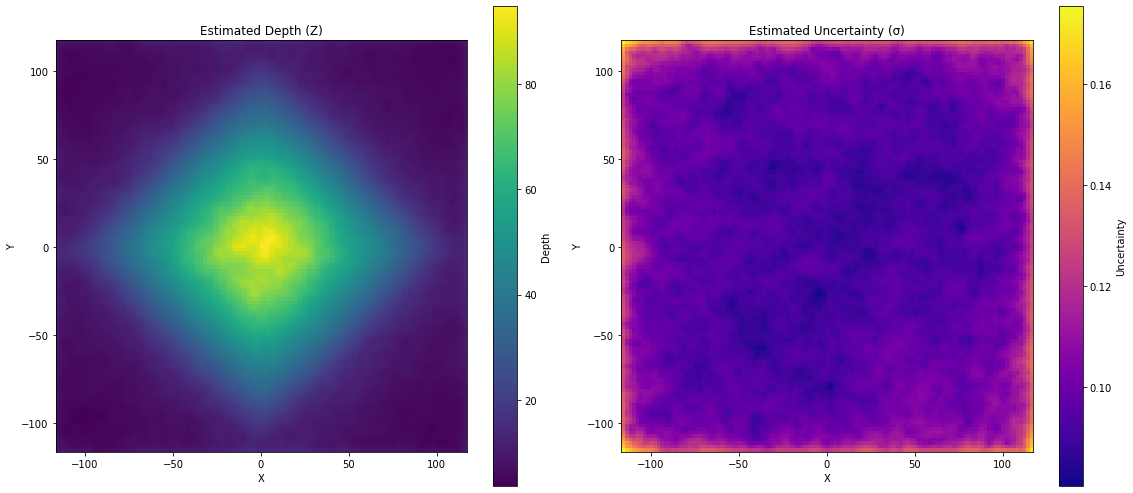

In [229]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Load Data ---
cur_folder = os.path.abspath(os.path.curdir)
data_path = os.path.join(cur_folder, 'mydata', "pyramid_noisy_point_cloud.csv")
df = pd.read_csv(data_path)

# --- User-Defined Parameters ---
hes = 2.0             # Horizontal error scale factor
de = 2.0              # Power factor for propagated uncertainty
grid_spacing = 2.0    # Grid spacing (adjust for performance or resolution)

# --- Define Grid ---
x_min, x_max = df["X"].min(), df["X"].max()
y_min, y_max = df["Y"].min(), df["Y"].max()
x_grid = np.arange(x_min, x_max + grid_spacing, grid_spacing)
y_grid = np.arange(y_min, y_max + grid_spacing, grid_spacing)

# --- Prepare Data ---
X = df["X"].values
Y = df["Y"].values
Z = df["Z"].values
sigma_v = df["Vertical_Uncertainty"].values
sigma_h = df["Horizontal_Uncertainty"].values

# --- Initialize Grids ---
grid_z = np.full((len(y_grid), len(x_grid)), np.nan)
grid_uncertainty = np.full((len(y_grid), len(x_grid)), np.nan)

# --- Gridding Loop ---
for i, y in enumerate(y_grid):
    for j, x in enumerate(x_grid):
        dx = X - x
        dy = Y - y
        distances = np.sqrt(dx**2 + dy**2)

        # ✅ Corrected propagated uncertainty formula
        sigma_p2 = sigma_v**2 * (1 + ((distances + hes * sigma_h) / grid_spacing) ** de)

        with np.errstate(divide='ignore', invalid='ignore'):
            weights = 1 / sigma_p2
            valid = weights > 0

        if np.any(valid):
            w = weights[valid]
            z_vals = Z[valid]
            z_est = np.sum(w * z_vals) / np.sum(w)
            unc_est = 1 / np.sum(w)
        else:
            z_est = np.nan
            unc_est = np.nan

        grid_z[i, j] = z_est
        grid_uncertainty[i, j] = np.sqrt(unc_est)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Subplot 1: Estimated Depth
c1 = axes[0].pcolormesh(x_grid, y_grid, grid_z, shading='auto', cmap='viridis')
axes[0].set_title("Estimated Depth (Z)")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].set_aspect('equal')
fig.colorbar(c1, ax=axes[0], label='Depth')

# Subplot 2: Estimated Uncertainty
c2 = axes[1].pcolormesh(x_grid, y_grid, grid_uncertainty, shading='auto', cmap='plasma')
axes[1].set_title("Estimated Uncertainty (σ)")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")
axes[1].set_aspect('equal')
fig.colorbar(c2, ax=axes[1], label='Uncertainty')

plt.tight_layout()
plt.show()

In the code cell you see a plan view of the estimated heights, as well as the uncertainty associated to them. In this case with the horizontal error scale factor set to two (leading to 
de = 2.0              # Power factor for propagated uncertainty

In [236]:
# --- User Parameters ---
hes = 1.0                          # Horizontal error scale
de = 2.0                          # Power factor for propagated uncertainty
grid_spacing = 1.0               # Grid spacing for output DEM
vertical_exaggeration = 3.0
sun_azimuth = 315
sun_elevation = 45
color_mode = "uncertainty_hillshade"   # 'sandy_hillshade' or 'uncertainty_hillshade'
view_elevation = 45
view_azimuth = -60

If you look at the image above we notice that the representation of the pyramid is significantly less good than the previously introduced IDW method, this is partially because we are not restricting the radius of influence of the data points. Since we in the process are estimating the vertical uncertainty as a function of distance we can also calculate when that uncertainty exceeds a threshold. For example the **International Hydrographic Organization** maintains IHO S-44, a technical standard that defines the minimum requirements for hydrographic surveys.

|Order|	Use Case | Depth Accuracy (95%)	| Horizontal Accuracy (95%)|
|-----|----------|----------------------|--------------------------|
|Special Order | Harbors, critical navigation areas |	±(0.25 m + 0.0075 × depth) |	2 m|
|Order 1a|	Ports, nearshore, harbors | ±(0.25 m + 0.01 × depth) | 5 m|
|Order 1|	General coastal navigation | ±(0.5 m + 0.02 × depth) | 5 m|
|Order 2|	Areas with less traffic, offshore | ±(1.0 m + 0.02 × depth)	| 20 m|
|Exclusive Order | Optional — higher than Special Order | Set by the authority | Set by the authority|



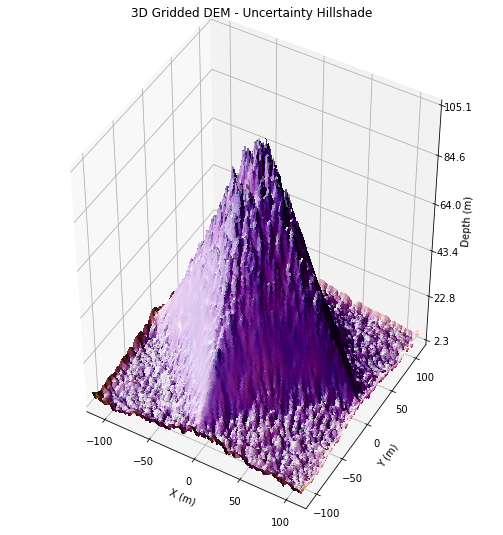

In [237]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource, Normalize, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D  # noqa

# --- Load Data ---
cur_folder = os.path.abspath(os.path.curdir)
data_path = os.path.join(cur_folder, 'mydata', "pyramid_noisy_point_cloud.csv")
df = pd.read_csv(data_path)



# --- Define Grid ---
x_min, x_max = df["X"].min(), df["X"].max()
y_min, y_max = df["Y"].min(), df["Y"].max()
x_grid = np.arange(x_min, x_max + grid_spacing, grid_spacing)
y_grid = np.arange(y_min, y_max + grid_spacing, grid_spacing)
grid_x, grid_y = np.meshgrid(x_grid, y_grid)

# --- Extract Data ---
X = df["X"].values
Y = df["Y"].values
Z = df["Z"].values
sigma_v = df["Vertical_Uncertainty"].values
sigma_h = df["Horizontal_Uncertainty"].values

# --- Initialize Output Grids ---
grid_z = np.full((len(y_grid), len(x_grid)), np.nan)
grid_uncertainty = np.full((len(y_grid), len(x_grid)), np.nan)

# --- Gridding Algorithm (Uncertainty-Weighted) ---
for i, y in enumerate(y_grid):
    for j, x in enumerate(x_grid):
        dx = X - x
        dy = Y - y
        distances = np.sqrt(dx**2 + dy**2)

        # Propagated uncertainty formula
        sigma_p2 = sigma_v**2 * (1 + ((distances + hes * sigma_h) / grid_spacing) ** de)

        with np.errstate(divide='ignore', invalid='ignore'):
            weights = 1 / sigma_p2
            valid = weights > 0

        if np.any(valid):
            w = weights[valid]
            z_vals = Z[valid]
            z_est = np.sum(w * z_vals) / np.sum(w)
            unc_est = 1 / np.sum(w)
        else:
            z_est = np.nan
            unc_est = np.nan

        grid_z[i, j] = z_est
        grid_uncertainty[i, j] = np.sqrt(unc_est)

# --- Normalize and Hillshade ---
z_exaggerated = grid_z * vertical_exaggeration
ls = LightSource(azdeg=sun_azimuth, altdeg=sun_elevation)

# Custom sandy colormap
sandy_colormap = LinearSegmentedColormap.from_list("sandy", ["#EEDC82", "#C2B280", "#A68B5B"], N=256)

z_norm = Normalize(vmin=np.nanmin(grid_z), vmax=np.nanmax(grid_z))
u_norm = Normalize(vmin=np.nanmin(grid_uncertainty), vmax=np.nanmax(grid_uncertainty))

# Compute hillshaded facecolors
hillshade_sandy = ls.shade(z_exaggerated, cmap=sandy_colormap, blend_mode='soft', vert_exag=vertical_exaggeration)

# FIXED: apply plasma colormap manually and then hillshade using shade_rgb
plasma_colormap = plt.get_cmap('plasma')
uncertainty_rgba = plasma_colormap(u_norm(grid_uncertainty))  # Apply colormap
hillshade_uncertainty = ls.shade_rgb(uncertainty_rgba[:, :, :3], z_exaggerated)  # Only RGB for shading


# --- Choose Colormap for 3D Plot ---
if color_mode == "sandy_hillshade":
    facecolors = hillshade_sandy
elif color_mode == "uncertainty_hillshade":
    facecolors = hillshade_uncertainty
else:
    raise ValueError("Invalid color_mode. Choose 'sandy_hillshade' or 'uncertainty_hillshade'.")

# --- 3D Plot ---
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(grid_x, grid_y, z_exaggerated, facecolors=facecolors,
                rstride=1, cstride=1, linewidth=0, antialiased=False)

# Adjust z ticks to show original (non-exaggerated) values
z_ticks_exaggerated = np.linspace(z_exaggerated.min(), z_exaggerated.max(), num=6)
z_tick_labels = np.linspace(grid_z.min(), grid_z.max(), num=6)
ax.set_zticks(z_ticks_exaggerated)
ax.set_zticklabels([f"{val:.1f}" for val in z_tick_labels])

# Axis limits and aspect
x_range = x_grid.max() - x_grid.min()
y_range = y_grid.max() - y_grid.min()
z_range = grid_z.max() - grid_z.min()

ax.set_xlim(x_grid.min(), x_grid.max())
ax.set_ylim(y_grid.min(), y_grid.max())
ax.set_zlim(z_exaggerated.min(), z_exaggerated.max())
ax.set_box_aspect([x_range, y_range, z_range * vertical_exaggeration])

# Labels
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Depth (m)")
ax.set_title(f"3D Gridded DEM - {color_mode.replace('_', ' ').title()}")

# Camera angle
ax.view_init(elev=view_elevation, azim=view_azimuth)
plt.show()

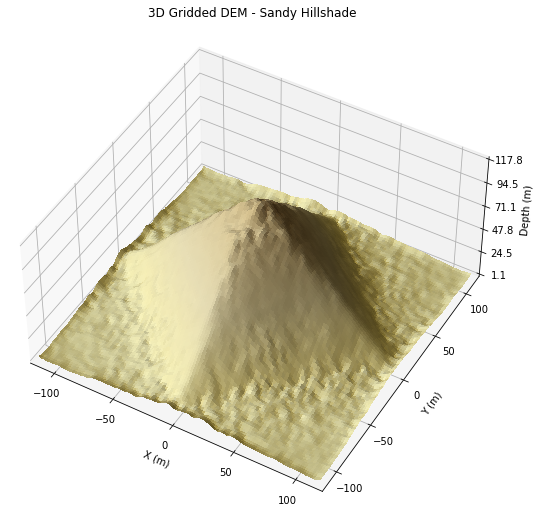

In [241]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource, Normalize, LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D  # noqa

# --- User Parameters ---
grid_spacing = 2.0
hes = 2.0
de = 2.0
vertical_exaggeration = 1.0
sun_azimuth = 315
sun_elevation = 45
color_mode = "sandy_hillshade"  # or "uncertainty_hillshade"
view_elevation = 45
view_azimuth = -60

# --- Load Data ---
cur_folder = os.path.abspath(os.path.curdir)
data_path = os.path.join(cur_folder, 'mydata', "pyramid_noisy_point_cloud.csv")
df = pd.read_csv(data_path)

# --- Extract Data ---
X = df["X"].values
Y = df["Y"].values
Z = df["Z"].values
sigma_v = df["Vertical_Uncertainty"].values/10
sigma_h = df["Horizontal_Uncertainty"].values/10

# Avoid divide-by-zero
sigma_v = np.where(sigma_v < 1e-6, 1e-6, sigma_v)

# --- Define Grid ---
x_min, x_max = df["X"].min(), df["X"].max()
y_min, y_max = df["Y"].min(), df["Y"].max()
x_grid = np.arange(x_min, x_max + grid_spacing, grid_spacing)
y_grid = np.arange(y_min, y_max + grid_spacing, grid_spacing)
grid_x, grid_y = np.meshgrid(x_grid, y_grid)

# --- Initialize Output Grids ---
grid_z = np.full((len(y_grid), len(x_grid)), np.nan)
grid_uncertainty = np.full((len(y_grid), len(x_grid)), np.nan)

# --- Gridding Loop with IHO Order 1 Filtering ---
for i, y in enumerate(y_grid):
    for j, x in enumerate(x_grid):
        dx = X - x
        dy = Y - y
        distances = np.sqrt(dx**2 + dy**2)

        # IHO Order 1 standard deviation (1σ)
        sigma_iho = 0.50 + 0.02 * Z

        # Max valid distance per point based on propagated uncertainty limit
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = (sigma_iho**2 / sigma_v**2) - 1
            valid_radius = ratio > 0
            d_max = np.full_like(distances, np.nan)
            d_max[valid_radius] = (ratio[valid_radius])**(1/de) * grid_spacing - hes * sigma_h[valid_radius]

        valid = (distances <= d_max) & (d_max > 0)

        if np.any(valid):
            dist_v = distances[valid]
            sigma_v_v = sigma_v[valid]
            sigma_h_v = sigma_h[valid]
            Z_v = Z[valid]

            sigma_p2 = sigma_v_v**2 * (1 + ((dist_v + hes * sigma_h_v) / grid_spacing) ** de)
            weights = 1 / sigma_p2

            z_est = np.sum(weights * Z_v) / np.sum(weights)
            unc_est = 1 / np.sum(weights)
        else:
            z_est = np.nan
            unc_est = np.nan

        grid_z[i, j] = z_est
        grid_uncertainty[i, j] = np.sqrt(unc_est)

# --- Sanity Check ---
if np.all(np.isnan(grid_z)):
    raise ValueError("All grid values are NaN — no soundings passed IHO Order 1 uncertainty cutoff.")

# --- Normalize & Hillshading ---
z_exaggerated = np.nan_to_num(grid_z * vertical_exaggeration, nan=np.nanmin(grid_z))

ls = LightSource(azdeg=sun_azimuth, altdeg=sun_elevation)

sandy_colormap = LinearSegmentedColormap.from_list("sandy", ["#EEDC82", "#C2B280", "#A68B5B"], N=256)
z_norm = Normalize(vmin=np.nanmin(grid_z), vmax=np.nanmax(grid_z))
u_norm = Normalize(vmin=np.nanmin(grid_uncertainty), vmax=np.nanmax(grid_uncertainty))

# Hillshading with sandy colormap
hillshade_sandy = ls.shade(z_exaggerated, cmap=sandy_colormap, blend_mode='soft', vert_exag=vertical_exaggeration)

# Hillshading with uncertainty colormap
plasma_colormap = plt.get_cmap('plasma')
uncertainty_rgba = plasma_colormap(u_norm(grid_uncertainty))
hillshade_uncertainty = ls.shade_rgb(uncertainty_rgba[:, :, :3], z_exaggerated)

# --- Choose Texture ---
if color_mode == "sandy_hillshade":
    facecolors = hillshade_sandy
elif color_mode == "uncertainty_hillshade":
    facecolors = hillshade_uncertainty
else:
    raise ValueError("Invalid color_mode. Choose 'sandy_hillshade' or 'uncertainty_hillshade'.")

# --- 3D Plot ---
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(grid_x, grid_y, z_exaggerated, facecolors=facecolors,
                rstride=1, cstride=1, linewidth=0, antialiased=False)

# Z ticks
z_ticks_exaggerated = np.linspace(z_exaggerated.min(), z_exaggerated.max(), num=6)
z_tick_labels = np.linspace(np.nanmin(grid_z), np.nanmax(grid_z), num=6)
ax.set_zticks(z_ticks_exaggerated)
ax.set_zticklabels([f"{val:.1f}" for val in z_tick_labels])

# Axis limits and aspect
x_range = x_grid.max() - x_grid.min()
y_range = y_grid.max() - y_grid.min()
z_range = np.nanmax(grid_z) - np.nanmin(grid_z)

ax.set_xlim(x_grid.min(), x_grid.max())
ax.set_ylim(y_grid.min(), y_grid.max())
ax.set_zlim(z_exaggerated.min(), z_exaggerated.max())
ax.set_box_aspect([x_range, y_range, z_range * vertical_exaggeration])

# Labels
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Depth (m)")
ax.set_title(f"3D Gridded DEM - {color_mode.replace('_', ' ').title()}")

ax.view_init(elev=view_elevation, azim=view_azimuth)
plt.show()


### **Determining the Optimal Grid Cell Size for MBES Bathymetry Data**  

Choosing the right **grid cell size** for **multibeam echosounder (MBES) bathymetry** data depends on several factors, including **depth, sounding density, survey resolution, and intended use**. The factors to consider include the following:

- Sounding density
    - swath centric view: the inter-ping and inter-beam distance
    - area centric view: the number of soundings per unit area
- Beam footprint size
    - swath centric view: depth dependent, Nyquist spatial sampling frequency should be achieved => cell size should be no smaller than half the largest footprint size
    - area centric view: The cell size should not be smaller than half that of the largest footprint size
- Survey area and purpose
    - this is not data driven - rather the survey should be designed in such manner that the footprint sizes are commensurate with the purpose of the survey. The grid size should then be defined by the Nyquist criterion which leads to the requirement for a cell size half that of the smallest feature to be detected
    
If the data warrants a high resolution it may warrant a hierarchical grid i.e., a composite set of grids with different cell sizes dependent on the scale at which it is represented.

---

## **1. Key Factors to Consider**
### **A. Sounding Density (Ping and Beam Spacing)**
- MBES systems collect data as a **swath**, and the density of soundings per unit area affects the grid resolution.
- The **ideal grid cell size** should be small enough to preserve bathymetric detail but not so small that it introduces noise or gaps.

### **B. Beam Footprint Size (Depth-Dependent)**
- The **footprint of each beam** grows with depth due to beam spreading.
- A common rule of thumb is to set the **grid cell size to be no smaller than half the beam footprint**.

### **C. Survey Area and Purpose**
- **High-resolution surveys (harbor, pipeline, archaeology):** **0.5 m – 2 m**
- **Coastal mapping (shallow water):** **2 m – 5 m**
- **Continental shelf surveys:** **5 m – 25 m**
- **Deep ocean mapping:** **50 m – 500 m**

---

## **2. Methods for Determining Grid Cell Size**

### **Method 1: Beam Footprint Calculation**
**Formula for Across-Track Beam Footprint Size**  

$$\text{Beam Footprint} = 2 \times \text{Depth} \times \tan\left(\frac{\text{Beam Angle}}{2}\right)$$

- Example:  
  - Depth: 100 m  
  - Beam Angle (for a single beam): 1°  
  - $\tan(0.5°) \approx 0.0087$  
  - $Beam Footprint = 2 \times 100 \times 0.0087 = 1.74 m$  
  - Suggested Grid Size: ~0.9 m (half of 1.74 m)

### **Method 2: Swath Width and Ping Rate**
**Estimate Cell Size Using Swath Width**  

$$\text{Grid Cell Size} = \frac{\text{Swath Width}}{\text{Number of Soundings Across Swath}}$$

- Example:  
  - Swath width at 100 m depth (assuming a 120° swath) ≈ 346 m  
  - 256 soundings per swath  
  - $Grid Cell Size = \frac{346}{256} \approx 1.35 m$ 
  - Suggested Grid Size: ~1.5 m  

### **Method 3: Nyquist Sampling Rate (Twice the Smallest Feature Size)**
- If you need to resolve a 2-meter-wide feature, use a 1-meter grid (Nyquist criterion).
- If MBES data has high noise levels, increasing the grid size (e.g., 2× or 4× footprint) helps filter noise.

---

## **3. Recommended Grid Sizes Based on Depth**
| **Depth Range** | **Typical Swath Width** | **Recommended Grid Size** |
|---------------|------------------|-------------------|
| **0 – 30 m** | 3 × depth | **0.5 – 2 m** |
| **30 – 100 m** | 3 × depth | **2 – 5 m** |
| **100 – 500 m** | 3 × depth | **5 – 25 m** |
| **> 500 m** | 3 × depth | **50 – 500 m** |

---

## **4. Practical Recommendations**
Use at least half the beam footprint as the grid size (avoids oversampling).    
For large areas, consider hierarchical grids (e.g., 1m in shallow, 5m in deep).  


<img align="left" width="6%" style="padding-right:10px; padding-top:10px;" src="images/refs.png">

## Useful References

### Definitions

- [S32 IHO Hydrographic Dictionary](http://iho-ohi.net/S32/engView.php)
- [EPSG database](https://epsg.org/home.html)

### Learning Materials

- [pygis.io](https://pygis.io/docs/a_intro.html)
- [Choosing a Map Projection](https://link.springer.com/book/10.1007/978-3-319-51835-0). 
- [projection wizard](https://projectionwizard.org)
- [projection wizard paper](https://berniejenny.info/pdf/2016_Savric_etal_ProjectionWizard.pdf).


### Python and Jupyter Notebooks

- [The Python website](http://www.python.org/)
- [PEP8 -- Style Guide for Python Code](https://www.python.org/dev/peps/pep-0008/)
- [The Jupyter Notebook manual](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html)

  - [Browser compatibility](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#browser-compatibility)
  - [The interface page](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
  - [The Markdown page](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html)
 
- Excellent free e-books to learn more about Python and Data Science:
  - [*Think Python 2nd Edition* by Allen B. Downey](http://greenteapress.com/wp/think-python-2e/)
  - [*Python Data Science Handbook* by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/)

<img align="left" width="5%" style="padding-right:10px;" src="images/email.png">

*For issues or suggestions related to this notebook, write to: epom@ccom.unh.edu*